# <center> DATA ANALYSIS NOTEBOOK <center>

This notebook was used to run the analyses and produce most of the images in the paper.

> _Overview:_
> - Get baseline predictions of the different models:
>    - Bin by bin (pointwise)
>    - Integrating the area of the central gene.
> - Compare model performances
> - **Input perturbations**: _How does nascent transcription change when we perturb the inputs?_
> - **Input attributions**: _What is required in the input to predict a given output?_


### Packages

In [5]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import pandas as pd
from pathlib import Path
from scipy.integrate import simpson
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

from matplotlib import gridspec
from PIL import Image

from scipy.ndimage import gaussian_filter

import matplotlib.cm as cm
from scipy.ndimage import rotate

plt.rcParams['font.family'] = 'Nimbus Roman'

### Functions

In [16]:
def read_gene_positions(csv_path, resolution=1):
    """ 
    This function reads a csv containing genes and enhancers (entities), and creates a dictionary with the relative coordinates of
    all entities to the TSS of the reference gene (central gene), which gives name to the sample.

    Args:
        csv_path: path to the csv with ref genes, entities and their relative coordinates.
        resolution: distance unit we want our relative distances to be given with (1-> bp, 1000->kbp)

    Returns:
        pos_dict: dictionary given pos_dict[ref gene][entity_name] = (rel_start, rel_end)
    """
    # Load the results from a CSV file
    df = pd.read_csv(csv_path, sep="\t")
    
    # Initialize the dictionary to store positions
    pos_dict = {}
    
    # Filter the DataFrame to get only gene entities 
    gene_entities = df[df['Entity_ID'].str.startswith('ENSMUSG')]  # Adjust the condition according to your data
    
    for _, row in gene_entities.iterrows():
        ref_gene_id = row['Ref_gene']
        entity_id = row['Entity_ID']
        rel_start = int(round(row['Entity_rel_Start'] / resolution))
        rel_end = int(round(row['Entity_rel_End'] / resolution))
        
        # Ensure the dictionary has the necessary structure
        if ref_gene_id+'_forward' not in pos_dict:
            pos_dict[ref_gene_id+'_forward'] = {}
        
        # Store the scaled and rounded start and end positions
        pos_dict[ref_gene_id+'_forward'][entity_id+'_forward'] = [rel_start, rel_end]
    
    return pos_dict


def _get_predictions(results_path: Path, N_BINS: int, condition_list: list):
    """
    This function reads the prediction files that EIR yields for each target (bin_condition, e.g. -150_ctrl) in the 
    test (eirpredict) setting. Predictions are then converted into dataframes. 
    
    Args:
        results_path: path where the predictions are stored
        N_BINS: number of the bins to one side of the central bin (200 normally, 57 for the Enformer predictions).
        condition_list: list of conditions. As of now ["_ctrl"], but can be extended to other target conditions.
    
    Returns:
        ids: names of the samples
        predicted: predicted untransformed values
        actual: actual values
    """
    # Lists to store DataFrames for concatenation
    predicted_dfs = []
    actual_dfs = []

    for condition in condition_list:
        for i in range(-N_BINS, N_BINS + 1):
            file_path = results_path / f"expression_output/{i}{condition}/predictions.csv"
            predictions = pd.read_csv(file_path).set_index('ID')

            # Apply ReLU to model predictions
            predictions = predictions.clip(lower=0)

            # Prepare data for concatenation.
            predicted_column = predictions[f"{i}{condition} Untransformed"].rename(f"{i}{condition}")
            actual_column = predictions["True Label Untransformed"].rename(f"{i}{condition}")

            predicted_dfs.append(predicted_column)
            actual_dfs.append(actual_column)

    # Concatenate all DataFrames horizontally
    predicted = pd.concat(predicted_dfs, axis=1)
    actual = pd.concat(actual_dfs, axis=1)
    ids = list(predicted.index)


    return ids, predicted, actual

def plot_target_predictions(savepath, line_p, line_a, id, rel_start, rel_end, pred_area):
    """ 
    Plot the predicted profiles. 
    """
    fig, axs =plt.subplots(2, figsize=(8,4), sharex = True)
    axs[0].fill_between(np.arange(-200,201),line_p, lw=1, color='royalblue',alpha=.3, label="Predicted expression control")
    axs[1].fill_between(np.arange(-200,201),line_a, lw=1, color='silver', alpha=.6, label="Actual expression control")
    #plt.plot(np.arange(len(line_p)),line_p, lw=1, color='darkred', label=f"{simpson(line_p[TSS:END])/WIDTH}")
    #plt.plot(np.arange(len(line_a)),line_a, lw=1, color='darkgreen', label=f"{simpson(line_a[TSS:END])/WIDTH} {END}")
    #plt.plot(TSS,1,'go')
    #plt.plot(END,1,'ro')
    # for i in range(len(axs)):
    #     axs[i].set_ylim(-10,50)
    #     axs[i].set_xlim(-200,200)
    #     axs[i].set_ylabel("Reads", fontsize=12)
    #     rect= patches.Rectangle((-75,-5),70,40, edgecolor='k', facecolor='none', linewidth=2)
    #     axs[i].add_patch(rect) 
    #     if i > 1:
    #         axs[i].annotate('', xy=(-50,10), xytext=(-50, 30), arrowprops=dict(arrowstyle='-|>,head_width=0.2,head_length=0.5', color='k'))             
    axs[1].set_xlabel("Distance from TSS (kbp)", fontsize=12)
    axs[0].plot([rel_start-200, rel_end-200],[50,50], label=f"Rel_area={pred_area}")     
    fig.legend(ncol=2, fancybox=True, shadow=True, fontsize=8)
    fig.savefig(savepath / f"{id}_prediction.png", dpi=200)
    plt.close(fig)

def extend_df(df):
    """ 
    Extend the gene-enhancer relationships df to add meaningful columns, e.g.
    * Number of genes between the given enhancer and the promoter of the central gene.
    * Whether the enhancer is adjacent to the measured gene or not.
    * Area under the central gene (baseline and when the given enhancer is silenced in silico).
    """
    
    # EP_distance calculation
    df['EP_distance'] = abs((df['Entity_rel_Start'] + df['Entity_rel_End']) / 2)
    
    # Initialize new columns
    df['Genes_in_between'] = 0
    df['Adjacent'] = 0
    df['Area'] = 0
    
    for index, row in df.iterrows():
        # Filter for entities related to the current reference gene and are genes (ENSMUSG)
        related_genes = df[(df['Ref_gene'] == row['Ref_gene']) & (df['Entity_ID'].str.startswith('ENSMUSG'))]
        
        # Determine the side of TSS the current entity is on
        entity_side = np.sign((row['Entity_rel_Start'] + row['Entity_rel_End']) / 2)
        
        # Count genes that are closer to the TSS than the current entity and on the same side
        closer_genes = related_genes[(np.sign((related_genes['Entity_rel_Start'] + related_genes['Entity_rel_End']) / 2) == entity_side) &
                                     (abs((related_genes['Entity_rel_Start'] + related_genes['Entity_rel_End']) / 2) < abs((row['Entity_rel_Start'] + row['Entity_rel_End']) / 2))]
        
        df.loc[index, 'Genes_in_between'] = len(closer_genes)
        
        # Set 'Adjacent' to 1 if there are no genes between this entity and the ref_gene
        df.loc[index, 'Adjacent'] = 1 if len(closer_genes) == 0 else 0
    
    return df

def filter_and_extend_gene_enhancer_table(samples_index_path: Path, samples_data_path: Path, perturbed_table_path: Path, chrom_to_keep: str = 'chr4'):
    """ 
    This function filters the genes and gene-enhancer combinations to keep and adds the extra columns required for downstream tasks.
    """
    # Load the first table and extract Ref_gene and Entity_ID pairs
    samples_index_df = pd.read_csv(samples_index_path)
    ref_entity_pairs = set(samples_index_df['ID'].apply(lambda x: tuple(x.rsplit('_', 2)[:2])))

    # Additionally, include Ref_gene as both Ref_gene and Entity_ID
    ref_genes = set([pair[0] for pair in ref_entity_pairs])
    for ref_gene in ref_genes:
        ref_entity_pairs.add((ref_gene, ref_gene))

    # Load the second table
    samples_data_df = pd.read_csv(samples_data_path, sep='\t')
    samples_data_df = samples_data_df[(samples_data_df['Ref_gene_chromosome']== chrom_to_keep)] # Filter only genes from test chromosome

    samples_data_df = extend_df(samples_data_df)

    # Filter rows based on whether the (Ref_gene, Entity_ID) tuple matches the reference set
    filtered_df = samples_data_df[
        samples_data_df.apply(lambda row: (row['Ref_gene'], row['Entity_ID']) in ref_entity_pairs, axis=1)
    ]

    # Save the filtered DataFrame to a new CSV file if needed
    filtered_df.to_csv(perturbed_table_path, index=False)

def calculate_area_gene(line_p, line_a, ID, pos_dict, N_BINS):
    """ 
    Args:
        line_p: vector of predicted values
        line_a: vector of actual values
        ID: reference gene, i.e. sample name
        pos_dict: dictionary with relative gene coordinates
        N_BINS: which length do we set as a threshold to integrate (in the new resolution).
    """
    seq_center = int(len(line_p)//2)
    rel_start = seq_center + pos_dict[ID][ID][0] if (seq_center + pos_dict[ID][ID][0]) > 0 else 0
    rel_end = seq_center + pos_dict[ID][ID][1] if (seq_center + pos_dict[ID][ID][1]) < 2*N_BINS+1 else 2*N_BINS+1

    WIDTH = max(1, int(rel_end - rel_start))

    # Appending area
    pred_area = simpson(line_p[rel_start:rel_end])/WIDTH
    actual_area = simpson(line_a[rel_start:rel_end])/WIDTH

    return pred_area, actual_area, rel_start, rel_end



def calculate_correlations(results_path: Path, gene_pos_path: Path, figure_path: Path, input_table_path: Path,  N_BINS: int = 200, condition_list = ["_ctrl"], resolution: int = 1000):
    """
    This function returns a set of dictionaries containing the actual EU-seq values and the predicted values. 
    This is done both on a bin by bin basis and integrated over the target gene length (normalized by gene length).
    """

    # Storing gene position's dict:

    pos_dict = read_gene_positions(gene_pos_path, resolution)
    ids, predicted, actual = _get_predictions(results_path, N_BINS, condition_list)
    df = pd.read_csv(input_table_path)

    # Normalized Area per bin for the target gene (central gene in observation window)
    pred_list_A_per_bin_dict = {}
    actual_list_A_per_bin_dict = {}

    # Predicted and actual EU-seq values in all positions:
    pred_list_values_dict = {}
    actual_list_values_dict = {}

    for condition in condition_list:
        pred_list_A_per_bin_dict[condition] = []
        actual_list_A_per_bin_dict[condition] = []
        pred_list_values_dict[condition] = []
        actual_list_values_dict[condition] = []

    for ID,line_p,line_a in zip(ids,predicted.values,actual.values):
        if ("_rev" not in ID): #Only add the forward strand to the analyses
            for condition in condition_list:
                # Extend binwise prediction and target lists
                pred_list_values_dict[condition].extend(list(line_p))
                actual_list_values_dict[condition].extend(list(line_a))

                # Extend area predictions
                pred_area, actual_area, rel_start, rel_end = calculate_area_gene(line_p, line_a, ID, pos_dict, N_BINS)

                pred_list_A_per_bin_dict[condition].extend([pred_area])
                actual_list_A_per_bin_dict[condition].extend([actual_area])

                # Adding area to extended table:
                gene = ID.split('_')[0]
                df.loc[(df['Ref_gene'] == gene) & (df['Entity_ID'] == gene),'Area'] = pred_area #Edit existing table

            PLOT = True
            ID_LIST = ["ENSMUSG00000078673.10_forward","ENSMUSG00000067261.4_forward","ENSMUSG00000028234.6_forward","ENSMUSG00000028280.9_forward","ENSMUSG00000035969.15_forward"]
            if PLOT and (ID in ID_LIST):
                print(gene, pred_area)
                plot_target_predictions(figure_path, line_p, line_p, ID, rel_start, rel_end, pred_area)

    df.to_csv(input_table_path, index=False)

    return pred_list_A_per_bin_dict, actual_list_A_per_bin_dict, pred_list_values_dict, actual_list_values_dict

def add_gene_area_after_enhancer_perturbation(results_path: Path, gene_pos_path: Path, figure_path: Path, input_table_path: Path,  N_BINS: int = 200, condition_list = ["_ctrl"], resolution: int = 1000):
    """
    This function reopens the csv file with reference genes and enhancers and edits the area under the reference gene when silencing a given enhancer.
    """
    # Storing gene position's dict:

    pos_dict = read_gene_positions(gene_pos_path, resolution)
    ids, predicted, actual = _get_predictions(results_path, N_BINS, condition_list)
    df = pd.read_csv(input_table_path)

    for ID,line_p,line_a in zip(ids,predicted.values,actual.values):
        seq_center = int(len(line_p)//2)
        gene = ID.split('_')[0]
        enhancer = ID.split('_')[1]
        rel_start = seq_center + pos_dict[gene+'_forward'][gene+'_forward'][0] if (seq_center + pos_dict[gene+'_forward'][gene+'_forward'][0]) > 0 else 0
        rel_end = seq_center + pos_dict[gene+'_forward'][gene+'_forward'][1] if (seq_center + pos_dict[gene+'_forward'][gene+'_forward'][1]) < 2*N_BINS+1 else 2*N_BINS+1

        WIDTH = max(1, int(rel_end - rel_start))

        # Appending area
        pred_area = simpson(line_p[rel_start:rel_end])/WIDTH

        # Adding area to extended table:
        df.loc[(df['Ref_gene'] == gene) & (df['Entity_ID'] == enhancer),'Area'] = pred_area #Edit existing table

        PLOT = True
        ID_LIST = ["ENSMUSG00000078673.10","ENSMUSG00000067261.4"]
        if PLOT and (gene in ID_LIST):
            plot_target_predictions(figure_path, line_p, line_a, ID, rel_start, rel_end, pred_area)

    df.to_csv(input_table_path, index=False)

def plot_correlations(figure_path: Path, pred_list_values: list, actual_list_values: list, title: str, cmap: colors.Colormap = "afmhot", binlims: tuple = (0,50), density: bool =True, DELTA:bool=False):
    """ 
    This function plots predicted vs. actual values and provides the Spearman and Pearson correlations of the regressions. 
    The style of the plot changes depending on whether the predictions are at a bin level or a gene level.
    """
    # Get the counts histogram to plot correlation with density colormap
    counts, xedges, yedges, _ = plt.hist2d(actual_list_values,pred_list_values, bins=[np.linspace(binlims[0],binlims[1],200),np.linspace(binlims[0],binlims[1],200)], density=False)

    # Plot regression of single predicted values vs. real
    pearson_r = pearsonr(actual_list_values,pred_list_values)[0]
    spearman_r = spearmanr(actual_list_values,pred_list_values)[0]
    m, b = np.polyfit(actual_list_values, pred_list_values, deg=1)
    # Actual fit:
    a1, a2, a3 = np.polyfit(actual_list_values, pred_list_values, deg=2)
    # Regression from origin:
    #m_0 , _, _, _ = np.linalg.lstsq(np.array(actual_list_values)[:,np.newaxis], pred_list_values) #x needs to be a column vector for this function

    # Create the figure
    fig, ax = plt.subplots(figsize=(4,4))    
    min_val, max_val, step = (0,10,.1)
    if density:
        eps= 1
        # Counts matrix is transposed: the origin convention for plt.imshow is (top, left), for plt.hist2D is (bottom,left)
        counts[counts < eps] =1
        hist = ax.imshow(counts.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap=cmap,  norm=colors.LogNorm())
        _ = fig.colorbar(hist)
        _ = ax.axline(xy1=(0, b), slope=m, label=f'Linear fit:\n$ y = {m:.3f}x {b:+.3f}$\n$r_p:{pearson_r:.4f}$\n$r_s:{spearman_r:.4f}$', color="royalblue", ls="-", lw=1)
        #_ = ax.plot(np.arange(min_val,max_val,step), a1*(np.arange(min_val,max_val,step)**2)+a2*(np.arange(min_val,max_val,step))+a3, color='royalblue', ls = "--", lw=1, label= f"Polynomial fit:\n$y={a1:.3f}x^2+{a2:.3f}x+{a3:.3f}$")
        _ = ax.axis("scaled")
        _ = ax.set_xlim(min_val,max_val)
        _ = ax.set_ylim(min_val,max_val)
        _ = ax.set_xlabel("log$_2$(True +1)")
        _ = ax.set_ylabel("log$_2$(Predicted +1)")
        fig.legend(bbox_to_anchor=(.48,.8), fancybox=True, shadow=False, fontsize=7)
    else:
        _ = ax.plot(actual_list_values,pred_list_values, lw=0, marker='o',  markersize=1, markeredgewidth=0, color='k')
        _ = ax.axis("scaled")
        _ = ax.axline(xy1=(0, b), slope=m, label=f'Linear fit:\n$ y = {m:.3f}x {b:+.3f}$\n$r_p:{pearson_r:.4f}$\n$r_s:{spearman_r:.4f}$', color="royalblue", ls="-", lw=1)
        #ax.plot(np.arange(-20,200,1), a1*(np.arange(-20,200,1)**2)+a2*(np.arange(-20,200,1))+a3, color='royalblue', ls = "--", lw=1, label= f"Polynomial fit:\n$y={a1:.3f}x^2+{a2:.3f}x{a3:.3f}$")
        if DELTA:
            _ = ax.set_xlim(-20,20)
            _ = ax.set_ylim(-20, 20)
            _ = ax.set_xlabel("Actual $\Delta_{exp}$  (reads/kbp)")
            _ = ax.set_ylabel("Predicted $\Delta_{exp}$ (reads/kbp)")
            fig.legend(bbox_to_anchor=(.53,.87), fancybox=True, shadow=True, fontsize=8)
        else:
            _ = ax.set_xlim(0,200)
            _ = ax.set_ylim(0, 200)
            _ = ax.set_xlabel("Actual averaged expression (reads/kbp)")
            _ = ax.set_ylabel("Predicted averaged expression (reads/kbp)")
            fig.legend(bbox_to_anchor=(.53,.87), fancybox=True, shadow=True, fontsize=8)

    #ax.plot(np.arange(0,500,1), np.arange(0,500,1), color='k', ls = "dashed", lw=1)

    fig.savefig(figure_path / f"Regression_histogram_{title}.png", dpi=200, bbox_inches='tight')
    plt.close(fig)
    

def plot_chromatin_state_combinations(array_path: Path, figure_path: Path, skip_n_bins: int):
    """
    This function is aimed to visualize the different combinations of values for different chromatin marks, which define the chromatin states.   
    """
    H3K4me3 = np.array([])
    H3K27ac = np.array([])
    H3K27me3 = np.array([])

    for file in os.scandir(array_path):
            if "_rev" not in file.name:
                    array = np.load(file)

                    # Adding mark enrichment values to a long array
                    H3K4me3 = np.concatenate((H3K4me3,array[1][::skip_n_bins]), axis=0)
                    H3K27ac = np.concatenate((H3K27ac,array[2][::skip_n_bins]), axis=0)
                    H3K27me3 = np.concatenate((H3K27me3,array[3][::skip_n_bins]), axis=0)


    # Plotting the 3d combinations at all sites
    scaling_factor = 1 # Inputs were directly given in reads
    altitude, azimuth = 45,45
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(projection="3d")
    ax.view_init(altitude, azimuth)
    ax.grid(False)

    #ax.plot_surface(x_val, y_val, avg_att_mat, rstride=1,cstride=1,linewidth=0, cmap="terrain")#,  vmin=-2e-4, vmax=2e-4)
    ax.scatter(H3K4me3*scaling_factor, H3K27ac*scaling_factor, H3K27me3*scaling_factor,linewidth=0, alpha=.5, marker="o", edgecolors="none", c="k", s=.1, label="All states combined")#,  vmin=-2e-4, vmax=2e-4)

    # Directions
    zdirs = ((-1,-.2,0), 'y','z','y','y')
    xs = (250, 0,60,0, 30)
    ys = (10, 50, 10,20,120)
    zs = (2, -20, 50,17,5)

    labels = ("Active promoters", "Active enhancers", "Silenced\nchromatin","$P2$","P1")
    label_colors = ("#ff0000","blue","darkgreen","purple", "goldenrod")

    for zdir, x, y, z, label, c in zip(zdirs, xs, ys, zs, labels, label_colors):
        ax.text(x, y, z, label, zdir, color=c)


    # Arrow towards silenced branch:
    ax.quiver(0, 100, 5, 0,-20,0, color='goldenrod',lw=.7)
    ax.quiver(0, 50, 5, 0,-20,0, color='goldenrod',lw=.7)
    ax.quiver(30, 100, 5, 0,-20,0, color='goldenrod',lw=.7)
    ax.quiver(30, 50, 5, 0,-20,0, color='goldenrod',lw=.7)

    # Inwards arrow towards silenced branch for P2:
    ax.quiver(-10, 20, 8, -10,-20,0, color='purple',lw=.7)
    ax.quiver(-10, 20, -2, -10,-20,0, color='purple',lw=.7)
    #ax.quiver(50, 10, 10, -20,0,0, color='purple',lw=.7)




    ax.set_xlabel("H3K4me3")
    ax.set_xticks([0,200,400],[0,200,400], rotation=40)

    ax.set_ylabel("H3K27ac")
    ax.set_yticks([0,100,200],[0,100,200], rotation=-40)

    ax.set_zlabel("H3K27me3", rotation=180)
    ax.set_zticks([0,40,80],[0,40,80])

    fig.subplots_adjust(left=0.2, right=0.9, top=.95, bottom=0.05)
    fig.savefig(figure_path / "chromstates.png", dpi=200)
    plt.close(fig)


def read_target_attributions(results_path: Path,
                             figure_path: Path,
                             n_central_bins: int,
                             track_dict: dict,
                             l_in:int = 10001,
                             n_out:int=401,
                             n_in: int=4,
                             TRAIN_ATTR: bool = True,
                             SPLIT: int = None):

    """
    This function is aimed to read attribution arrays from the chromatin landscape branch. Attribution arrays score the 
    contribution of each position in the input arrays (4,10.001) towards each output node/position (401).
    Args:
        results_path: path where the attribution arrays are stored.
        figure_path: path where we want to store the outputs
        n_central_bins: number of central bins (from -N_BINS to  N_BINS+1)
        track_dict: dictionary containing the names of the tracks and plot details
        l_in: input length 
        n_out: number of output nodes
        n_in: number of input channels
        TRAIN_ATTR: whether this is a training or test run (folder structure changes).
        SPLIT: if Train, we need to know which of the stored batches it is

    Returns:
        Plots with attribution scores.
    """
    figure_path.mkdir(exist_ok=True, parents=True)

    N_BINS = n_central_bins // 2  # Number of bins from TSS that we want on one side
    N_IN_BINS = l_in // 2
    x_val = np.arange(-N_IN_BINS,N_IN_BINS+1)

    xlim = (-500,500)

    # Getting attributions:
    condition_list = ["_ctrl"]
    landscape_avg = {condition : np.zeros((n_in,l_in)) for condition in condition_list}

    for i in range(-N_BINS, N_BINS + 1):
        for condition in condition_list:
            # CHROMATIN MARK ATTRIBUTIONS:
            added_folders = f"/samples/{SPLIT}" if TRAIN_ATTR else "" # Different folder structure
            att_path = Path(results_path / f"{i}{condition}{added_folders}/attributions/gene_expression/{i}{condition}.npy")
            if os.path.exists(att_path):
                attributions = np.load(att_path)
                #if (i == -73) and (condition == "_ctrl"):
                fig, axs = plt.subplots(4, figsize=(8,2.7)) 
                for j,key in enumerate(track_dict.keys()):
                    name = track_dict[key]["name"]
                    axs[j].plot(x_val, abs(attributions[j]), label=name, lw=0, marker='o', markersize=0.8, markeredgecolor="none", color=track_dict[key]["color"])
                    axs[j].set_xlim((-5000,5001))
                    axs[j].set_ylim((0,np.max(attributions[1])))
                    axs[j].set_yticks([])
                    axs[-1].set_yticks([0,np.max(attributions[1])],[0,1])
                fig.savefig(figure_path / f"Chromatin_landscape_attributions_{i}_ctrl.png",dpi=200)
                plt.close(fig)

                # Add a small phase to remove high frequency fluctuations:
                eps = 10*np.random.rand(1)*np.random.choice([-1,1])
                
                centered_attr = np.roll(attributions, -10*i+int(eps),axis=1)
                landscape_avg[condition] += 1/n_out*(abs(centered_attr))

    SCALING_FACTOR = np.max([landscape_avg[cond] for cond in condition_list])

    
    for condition in condition_list:
        fig, ax = plt.subplots(figsize=(8,2.7))   
        sub_axes = plt.axes([.615, .57, .27, .27])  
        for i,key in enumerate(track_dict.keys()):
            name = track_dict[key]["name"]
            ax.plot(x_val, landscape_avg[condition][i]/SCALING_FACTOR, label=name, lw=0, marker='o', markersize=2, markeredgecolor="none", color=track_dict[key]["color"])
            sub_axes.plot(x_val, landscape_avg[condition][i]/SCALING_FACTOR, label=name, lw=0,marker='o',markersize=.5,markeredgecolor="none", color=track_dict[key]["color"])
        
        #sub_axes.set_xlim(xlim)
        sub_axes.set_xticks(np.arange(-5000,5001,5000),np.arange(-500,501,500))
        sub_axes.set_xlim((-5000,5000))
        sub_axes.set_yticks([])
        ax.set_xlim(xlim)
        ax.set_ylim(0,1) #(0,.002))
        ax.legend(loc='upper left')
        ax.set_ylabel("Attribution score")
        ax.set_xlabel("Distance to the predicted locus (kbp)")
        plt.subplots_adjust(bottom=0.2)
        ax.set_xticks(np.arange(-400,401,100),np.arange(-40,41,10))
        fig.savefig(figure_path / f"Landscape_absolute_average_{condition}.png", dpi=200)
        plt.close(fig)

def model_comparison(figure_path: Path, performance_dict: dict, color_list: list):
    """
    Creates bar plots comparin pearson and spearman correlations of the different models.
    """
    fig = plt.figure(figsize=(2.5,5))
    pos = 1
    shift = 8
    for i,model in enumerate(performance_dict.keys()):
        # if i == 0:
        #     for j in range(2):
        #         plt.plot(pos,complementary_dict[i]["Spearman"], marker='d', color='k', markersize=10, markeredgewidth=0)
        #         plt.plot(pos+shift,complementary_dict[i]["Pearson"], marker='d', color='k', markersize=10, markeredgewidth=0)
                
        plt.bar(pos, performance_dict[model]["Spearman"], label=f"{model}", color=color_list[i])
        plt.bar(pos+shift, performance_dict[model]["Pearson"], color=color_list[i])
        #plt.plot(pos,performance_dict[model]["Spearman"], marker='d', color='k', markersize=3, markeredgewidth=0)
        #plt.plot(pos+shift,performance_dict[model]["Pearson"], marker='d', color='k', markersize=3, markeredgewidth=0)
        pos += 1


    plt.xticks([3.5,11.5],["Spearman","Pearson"])
    plt.legend(loc="lower left", bbox_to_anchor=(-0.04,1.08), fontsize=6)
    plt.ylim((0,1))
    plt.ylabel(" Binwise correlation for log$_2$(reads +1)")
    plt.tight_layout()
    fig.savefig(figure_path / "Model_comparison.png", dpi=200)
    plt.close(fig)

def model_comparison_II(figure_path: Path, performance_dicts: list , color_list: list):
    """
    Creates bar plots comparin pearson and spearman correlations of the different models.
    """
    fig = plt.figure(figsize=(5,5))
    for j,performance_dict in enumerate(performance_dicts):
        print(performance_dict)
        marker = 'o' if j== 0 else 'x'
        task = 'binwise' if j==0 else 'area'
        for i,model in enumerate(performance_dict.keys()):
            plt.plot(performance_dict[model]["Pearson"],performance_dict[model]["Spearman"], color=color_list[i], marker=marker, label=f'{model} {task}')

    plt.legend()
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.ylabel("Spearman")
    plt.xlabel("Pearson")
    plt.tight_layout()
    fig.savefig(figure_path / "Model_comparison_II.png", dpi=200)
    plt.close(fig)

####################### ATTRIBUTIONS ####################

 
def plot_microc_original_and_rotated(pathlist: list, figure_path: Path, num_bins: int, window_of_observation: float, name: str):
    """ 
    This function plots the Micro-C contact maps (both original and rotated-cropped)  given a sample name.

    """
    bin_per_kbp = num_bins/window_of_observation #Unit (bin/kbp)
    max_shift = int(200*bin_per_kbp) # Distance to crop because it was rolled from the other side

    for p,path in enumerate(pathlist):
        for sample in os.scandir(path):
            if name in sample.name: # Nice example: "ENSMUST00000105369.7.npy" common "ENSMUST00000001565.14.npy" 
                microc_map = np.load(sample)
                fig = plt.figure(figsize=(8,4))
                #plt.imshow(microc_map, cmap="YlOrRd")
                # plt.plot(200*bin_per_kbp,50,marker="x")
                # plt.plot(-200*bin_per_kbp+313,50,marker="x")
                # plt.plot(313,50,marker="x")
                plt.imshow(microc_map, cmap="YlOrRd", vmin = -5, vmax = 0)
                # Real scale
                center_bin = np.shape(microc_map)[1]//2
                bin_pos = np.arange(13,np.shape(microc_map)[1],50)
                kbp_per_bin = 1/bin_per_kbp
                bin_val = (bin_pos-np.shape(microc_map)[1]//2)*kbp_per_bin #Unit (kbp/bin)
                bin_val = ["%.2f"%item for item in bin_val]
                plt.xticks(bin_pos,bin_val, rotation=90, fontsize=8)
                plt.xlabel("Distance in 1D sequence (kbp)", fontsize=10)
                # Careful! Scale is not the distance between points but the distance between interacting points in 1D! 
                bin_pos = np.arange(0,np.shape(microc_map)[0],25)
                bin_val = 2*bin_pos*kbp_per_bin #*(kbp_per_bin) + np.shape(avg_att_mat)[0]
                bin_val = ["%.2f"%item for item in bin_val]
                plt.yticks(bin_pos,bin_val, fontsize=8)
                if p == 0:
                    plt.xticks([])
                    plt.yticks([])
                plt.ylabel("Separation between\n interacting elements\n in 1D sequence (kbp)", fontsize=10)
                plt.colorbar()
                fig.savefig(figure_path / f"MicroC_input_{name}_{p}.png", dpi=200)
                plt.close(fig)



def plot_microc_attributions(figure_path, sample_ids, num_bins, window_of_observation, ATTR_type_list, conditions, sigma):

    """ 
    Plot the attribution maps for micro-c matrices
    
    """
    bin_per_kbp = num_bins/window_of_observation
    print(bin_per_kbp)
    max_shift = int(200*bin_per_kbp) # Distance to crop because it was rolled from the other side

    avg_att_mat_dict = {}
    for condition in conditions:
        avg_att_mat_dict[condition] = {}
        for ATTR_type in ATTR_type_list:
            avg_att_mat_dict[condition][ATTR_type] = np.zeros((129,626))

    for condition in conditions:
        for i in sample_ids:
            #path = Path(f"../runs/training_runs/gene_expression_exformer_unlimited_all_rotated/results/expression_output/{i}{condition}/samples/17880/attributions/contact_maps/{i}{condition}.npy") 
            path = Path(f"../runs/test_runs/gene_expression_microc_rotated_pure_conv/expression_output/{i}{condition}/attributions/contact_maps/{i}{condition}.npy") 
            att_mat = np.load(path)
            att_mat_rolled = np.roll(att_mat,-int(i*bin_per_kbp), axis = 1)

            avg_att_mat_dict[condition]["abs"] += 1/(len(sample_ids))*abs(att_mat_rolled)
            avg_att_mat_dict[condition]["signed"] += 1/(len(sample_ids))*att_mat_rolled

            if (i==199):

                fig_1 = plt.figure(figsize=(8,3))#(11.5, 5))
                gs = gridspec.GridSpec(2, 2, hspace=.2, wspace=.1, width_ratios=(5,0.1))
                ax = fig_1.add_subplot(gs[0, 0])
                ax.set_xticks([])
                fig_display = ax.imshow(np.flip(att_mat,axis=0),  cmap="seismic", vmin = -0.0002, vmax=0.0002)
                ax_II = fig_1.add_subplot(gs[1, 0])
                fig_display = ax_II.imshow(np.flip(att_mat_rolled,axis=0),  cmap="seismic", vmin = -0.0002, vmax=0.0002)
                cax = fig_1.add_subplot(gs[0, 1])
                # Add the colorbar
                plt.colorbar(fig_display, cax=cax)
                plt.tight_layout()
                fig_1.savefig(figure_path / f"Signed_attributions_{i}{condition}.png", dpi=200)
                plt.close(fig_1)

    for CONDITION in conditions:
        for ATTR_type in ATTR_type_list:
            avg_att_mat = avg_att_mat_dict[condition][ATTR_type] 
            avg_att_mat = gaussian_filter(avg_att_mat, sigma=sigma)
            avg_att_mat = np.flip(avg_att_mat[:,max_shift:-max_shift], axis = 0)

            # Assuming 'img' is your image data
            y_projected_mat = np.mean(avg_att_mat, axis=0)  # Compress along x-axis
            x_projected_mat = np.mean(avg_att_mat, axis=1)  # Compress along y-axis

            fig = plt.figure(figsize=(8,3))#(11.5, 5))
            gs = gridspec.GridSpec(1, 2, hspace=.2, wspace=.1, width_ratios=(5,0.1))

            # Main image
            ax = fig.add_subplot(gs[0, 0])
            # Create an axis for the colorbar
            cax = fig.add_subplot(gs[0, 1])
            if ATTR_type == "abs":
                img_display = ax.imshow(avg_att_mat, aspect='auto', cmap="inferno", vmin=0, vmax=0.5e-4)
                cbar = plt.colorbar(img_display, cax=cax)
                cbar.set_ticks([0,5e-5])
                cbar.set_ticklabels([0,1])
            else:
                img_display = ax.imshow(avg_att_mat, aspect='auto', cmap="seismic", vmin=-0.5e-4, vmax=0.5e-4)
                cbar = plt.colorbar(img_display, cax=cax)
                cbar.set_ticks([-5e-5,0,5e-5])
                cbar.set_ticklabels([-1,0,1])


            # Plot vertical dashed line
            ref_y = np.arange(len(avg_att_mat))
            ref_x = np.shape(avg_att_mat)[1]//2*np.ones_like(ref_y)
            im = ax.plot(ref_x,ref_y, "k--")


            # Plot diagonals from prediction point:
            diag_x = np.arange(np.shape(avg_att_mat)[0]) + np.shape(avg_att_mat)[1]//2
            diag_x2 = -np.arange(np.shape(avg_att_mat)[0]) + np.shape(avg_att_mat)[1]//2
            diag_y = np.arange(np.shape(avg_att_mat)[0])
            ax.plot(diag_x,diag_y, "b--", lw=.5)
            ax.plot(diag_x2,diag_y, "b--", lw=.5)

            # Real scale
            bin_pos = np.arange(11,np.shape(avg_att_mat)[1],25)
            #bin_val = (bin_pos-np.shape(avg_att_mat)[1]//2)*kbp_per_bin
            kbp_per_bin = 1/bin_per_kbp
            bin_val = (bin_pos-np.shape(avg_att_mat)[1]//2)*kbp_per_bin #Unit (kbp/bin)
            bin_val = ["%.2f"%item for item in bin_val]
            ax.set_xticks(bin_pos,bin_val, rotation=90)

            # Careful! Scale is not the distance between points but the distance between interacting points in 1D! 
            bin_pos = np.arange(0,np.shape(avg_att_mat)[0],25)
            bin_val = 2*bin_pos*kbp_per_bin # Unit (kbp/bin)
            bin_val = ["%.2f"%item for item in bin_val]
            ax.set_yticks(bin_pos,bin_val)


            ax.set_xlabel("Distance from the predicted point (kbp)",fontsize= 12)
            ax.set_ylabel("Separation between\n interacting elements\n in 1D sequence (kbp)",fontsize= 12)

            # # Top plot
            # axb = fig.add_subplot(gs[0, 0], sharex=ax)
            # axb.plot(np.arange(len(y_projected_mat)), y_projected_mat, color='k')
            # plt.setp(axb.get_xticklabels(), visible=False)
            # axb.set_ylabel("Averaged attribution score", fontsize= 8)

            # # Right plot
            # axl = fig.add_subplot(gs[1, 1], sharey=ax)
            # axl.plot(x_projected_mat, np.arange(len(x_projected_mat)), color='k')
            # plt.setp(axl.get_yticklabels(), visible=False)
            # axb.set_ylabel("Averaged attribution score", fontsize = 8)
            plt.subplots_adjust(bottom=0.25, left=.20)
            plt.tight_layout()
            fig.savefig(figure_path / f"Structural_attributions_{ATTR_type}_{CONDITION}_{sigma}.png", dpi=200)
            plt.close(fig)

##### Model benchmarks ######


def plot_benchmark_models_predictions(data_and_path_dict, results_path,target_samples, condition_list, READ_SCALING_FACTOR,PLOT_LIST, gene_pos_path, resolution, cmap = "binary"):
    """ 
    This function is aimed to compare the predicted profiles and performances between different models.
    """
    CREATE_DFS = True
    param_dict = {"CLASTER":{"n_central_bins":401,"N_BINS":200,"OUT_LEN":401},
                             "hyenadna":{"n_central_bins":31,"N_BINS":15,"OUT_LEN":31},
                             "Enformer":{"n_central_bins":115,"N_BINS":57,"OUT_LEN":115}}


    N_SAMPLES = 1295
    pos_dict = read_gene_positions(gene_pos_path, resolution)  # Storing gene position's dict:

    ### Claster and targets 
    MODEL = "CLASTER" #"Enformer"
    ids, predicted, actual = _get_predictions(results_path, param_dict[MODEL]["N_BINS"], condition_list)
    ids = ids[::2] # Keep only forward!
    predicted = predicted[~predicted.index.str.contains('_rev')].sort_index() 
    actual = actual[~actual.index.str.contains('_rev')].sort_index()


    ### hyenadna and Enformer
    MODEL = "hyenadna"
    pred_list_df_hyena= pd.DataFrame(data_and_path_dict[MODEL]["predictions"].reshape(N_SAMPLES,param_dict[MODEL]["OUT_LEN"]), columns = [f"{i}{cond}" for cond in condition_list for i in range(-param_dict[MODEL]["N_BINS"],param_dict[MODEL]["N_BINS"]+1)], index=target_samples.index).sort_index() 
    actual_list_df_hyena = pd.DataFrame(data_and_path_dict[MODEL]["actual"].reshape(N_SAMPLES,param_dict[MODEL]["OUT_LEN"]), columns = [f"{i}{cond}" for cond in condition_list for i in range(-param_dict[MODEL]["N_BINS"],param_dict[MODEL]["N_BINS"]+1)], index=target_samples.index).sort_index() 
    
    MODEL = "Enformer"
    pred_list_df_enformer= pd.DataFrame(data_and_path_dict[MODEL]["predictions"].reshape(N_SAMPLES,param_dict[MODEL]["OUT_LEN"]), columns = [f"{i}{cond}" for cond in condition_list for i in range(-param_dict[MODEL]["N_BINS"],param_dict[MODEL]["N_BINS"]+1)], index=target_samples.index).sort_index() 
    actual_list_df_enformer = pd.DataFrame(data_and_path_dict[MODEL]["actual"].reshape(N_SAMPLES,param_dict[MODEL]["OUT_LEN"]), columns = [f"{i}{cond}" for cond in condition_list for i in range(-param_dict[MODEL]["N_BINS"],param_dict[MODEL]["N_BINS"]+1)], index=target_samples.index).sort_index() 
    ###
    counter = 0

    # Normalized Area per bin for the target gene (central gene in observation window)
    A_per_gene_dict = {"Enformer":{"Predicted":[],"Actual":[]},"hyenadna":{"Predicted":[],"Actual":[]}}

    for id, line_pc, line_ac, line_ph, line_pe  in zip(ids,predicted.values,actual.values,pred_list_df_hyena.values, pred_list_df_enformer.values):
        #if counter < 50:   
         
        MODEL = "Enformer"
        N_BINS = param_dict[MODEL]["N_BINS"]
        MODEL_SHIFT = (param_dict["CLASTER"]["n_central_bins"] - param_dict[MODEL]["n_central_bins"])//2
        #MODEL_SHIFT = (param_dict["CLASTER"]["n_central_bins"] - param_dict["hyenadna"]["n_central_bins"])//2
        #ENFORMER_SHIFT = (param_dict["Enformer"]["n_central_bins"] - param_dict["hyenadna"]["n_central_bins"])//2
        pred_area_e, actual_area_e, *_ = calculate_area_gene(line_pe, line_ac[MODEL_SHIFT:-MODEL_SHIFT], id, pos_dict, N_BINS)
        #pred_area_e, actual_area_e, *_ = calculate_area_gene(line_pe[ENFORMER_SHIFT:-ENFORMER_SHIFT], line_ac[MODEL_SHIFT:-MODEL_SHIFT], id, pos_dict, N_BINS)
        A_per_gene_dict[MODEL]["Predicted"].append(pred_area_e)
        A_per_gene_dict[MODEL]["Actual"].append(actual_area_e)

        MODEL = "hyenadna"
        N_BINS = param_dict[MODEL]["N_BINS"]
        MODEL_SHIFT = (param_dict["CLASTER"]["n_central_bins"] - param_dict[MODEL]["n_central_bins"])//2
        pred_area_h, actual_area_h, *_ = calculate_area_gene(line_ph, line_ac[MODEL_SHIFT:-MODEL_SHIFT], id, pos_dict,N_BINS)
        A_per_gene_dict[MODEL]["Predicted"].append(pred_area_h)
        A_per_gene_dict[MODEL]["Actual"].append(actual_area_h)

        if id in PLOT_LIST:
            fig, axs =plt.subplots(nrows=4,ncols=1, figsize=(8,4), sharex = True)
            MODEL = "CLASTER" 
            axs[2].fill_between(np.arange(-param_dict[MODEL]["N_BINS"],param_dict[MODEL]["N_BINS"]+1),line_pc[:param_dict[MODEL]["n_central_bins"]]*READ_SCALING_FACTOR, lw=1, color='silver',alpha=.8, label="CLASTER")
            axs[3].fill_between(np.arange(-param_dict[MODEL]["N_BINS"],param_dict[MODEL]["N_BINS"]+1),line_ac[:param_dict[MODEL]["n_central_bins"]]*READ_SCALING_FACTOR, lw=1, color='black', alpha=.5, label="EU-seq target")
            axs[3].plot([-param_dict[MODEL]["N_BINS"]+MODEL_SHIFT,-param_dict[MODEL]["N_BINS"]+ MODEL_SHIFT+param_dict["hyenadna"]["n_central_bins"]],[10,10],color='k')
            #axs[2][1].fill_between(np.arange(-param_dict[MODEL]["N_BINS"],param_dict[MODEL]["N_BINS"]+1),line_pc[param_dict[MODEL]["n_central_bins"]:]*READ_SCALING_FACTOR, lw=1, color='royalblue', alpha=.9, label="Predicted expression treated")
            #axs[3][1].fill_between(np.arange(-param_dict[MODEL]["N_BINS"],param_dict[MODEL]["N_BINS"]+1),line_ac[param_dict[MODEL]["n_central_bins"]:]*READ_SCALING_FACTOR, lw=1, color='k', alpha=.6, label="Actual expression treated")
            
            MODEL = "hyenadna"
            axs[0].fill_between(np.arange(-param_dict[MODEL]["N_BINS"],param_dict[MODEL]["N_BINS"]+1),line_ph[:param_dict[MODEL]["n_central_bins"]]*READ_SCALING_FACTOR, lw=1, color='silver',alpha=.8,label=f"HyenaDNA-32k {pred_area_h}-{actual_area_h}" )
            #axs[0][1].fill_between(np.arange(-param_dict[MODEL]["N_BINS"],param_dict[MODEL]["N_BINS"]+1),line_ph[param_dict[MODEL]["n_central_bins"]:]*READ_SCALING_FACTOR, lw=1, color='royalblue', alpha=.9)

            MODEL = "Enformer"
            axs[1].fill_between(np.arange(-param_dict[MODEL]["N_BINS"],param_dict[MODEL]["N_BINS"]+1),line_pe[:param_dict[MODEL]["n_central_bins"]]*READ_SCALING_FACTOR, lw=1, color='silver',alpha=.8,label=f"Enformer {pred_area_e}-{actual_area_e}")
            #axs[1][1].fill_between(np.arange(-param_dict[MODEL]["N_BINS"],param_dict[MODEL]["N_BINS"]+1),line_pe[param_dict[MODEL]["n_central_bins"]:]*READ_SCALING_FACTOR, lw=1, color='royalblue', alpha=.9)
            
            model_list = ['HyenaDNA-32k','Enformer','CLASTER','Target']

            for i in range(len(axs)):
                axs[i].set_ylim((0,50))
                axs[i].legend()
                axs[3].set_xlabel(f"Distance from TSS (kbp)", fontsize=12)
                    
            axs[3].set_ylabel("Reads", fontsize=12)     
            #fig.legend( bbox_to_anchor=(.84,1.003),ncol=2, fancybox=True, shadow=True, fontsize=8)
            fig.savefig(Path("../figures/supplementary_figures/") / f"{id}.png", dpi=200)
            plt.close(fig)

        counter += 1

    # Correlations Hyena:
    MODEL = "hyenadna"
    plot_correlations(data_and_path_dict[MODEL]["figure_path"], np.log2(READ_SCALING_FACTOR*pred_list_df_hyena.values[:,:param_dict[MODEL]["n_central_bins"]].flatten()+1),  np.log2(READ_SCALING_FACTOR*actual_list_df_hyena.values[:,:param_dict[MODEL]["n_central_bins"]].flatten()+1), title=f"{MODEL}_performance_ctrl_smoothL1.png", cmap= "binary", binlims= (0,10), density =True, DELTA=False)
    plot_correlations(data_and_path_dict[MODEL]["figure_path"], A_per_gene_dict[MODEL]["Predicted"],A_per_gene_dict[MODEL]["Actual"] , title=f"{MODEL}_performance_ctrl_gene_avg.png", cmap= "binary", binlims= (0,10), density =False, DELTA=False)
    
    # Correlations Enformer:
    MODEL = "Enformer"
    plot_correlations(data_and_path_dict[MODEL]["figure_path"], np.log2(READ_SCALING_FACTOR*pred_list_df_enformer.values[:,:param_dict[MODEL]["n_central_bins"]].flatten()+1),  np.log2(READ_SCALING_FACTOR*actual_list_df_enformer.values[:,:param_dict[MODEL]["n_central_bins"]].flatten()+1), title=f"{MODEL}_performance_ctrl_smoothL1.png", cmap= "binary", binlims= (0,10), density =True, DELTA=False)
    plot_correlations(data_and_path_dict[MODEL]["figure_path"], A_per_gene_dict[MODEL]["Predicted"],A_per_gene_dict[MODEL]["Actual"] , title=f"{MODEL}_performance_ctrl_gene_avg.png", cmap= "binary", binlims= (0,10), density =False, DELTA=False)


def plot_perturbed_profiles(results_path: Path, figure_path: Path, N_BINS: int, SCALE : int, sample_name: str, PERT_TYPE: str):

    ids, predicted, actual = _get_predictions(results_path, N_BINS, condition_list = ["_ctrl"])

    cmap = plt.cm.terrain  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    norm = mpl.colors.Normalize(vmin=0, vmax=18)

    fig = plt.figure(figsize=(8,2))
    i = 0
    for index in predicted.index:
        ref_gene, entity_id, _ = index.split('_')
        if sample_name in index:
            # Get the normalized color index for the current loop iteration
            color = cmap(norm(i))
            plt.plot(np.arange(-N_BINS,N_BINS+1), predicted.loc[f"{index}"], color=color, lw=.8)
            start = table[(table["Ref_gene"] == ref_gene) & (table["Entity_ID"] == entity_id)]['Entity_rel_Start']/SCALE
            end = table[(table["Ref_gene"] == ref_gene) & (table["Entity_ID"] == entity_id)]['Entity_rel_End']/SCALE
            plt.plot([start,end],i+np.array([25,25]), color=color, lw=1.5)
            plt.xlabel("Distance from TSS (kbp)")
            plt.xlim((-200,200))
            plt.ylim((0,40))
            plt.ylabel("Reads")
            i += 1

    fig.tight_layout()
    fig.savefig(figure_path / f"Perturbed_profiles_{sample_name}_{PERT_TYPE}.png", dpi=200)


# Latent representation analysis
def visualize_filters(path: Path, 
                       savepath: Path,
                       first_validation_sample_index: int = 0, 
                       last_validation_sample_index: int=100, 
                       step: int = 1,
                       layer_name: str = ""): 
    """
     This function plots the intermediate outputs of the network. This is useful to understand what filters  
     are being created and what are their roles. 
    """

    import matplotlib as mpl
  
    latents = np.load(path / "latents.npy") 
  
    for i,sample in enumerate(latents[first_validation_sample_index:last_validation_sample_index:step]): 
        sample_name = sample[1] 
        sample_values = sample[0]
        n_filters_in_layer = sample_values.shape[0]
        print(np.min(sample_values), np.max(sample_values))
        fig, axs = plt.subplots(n_filters_in_layer, figsize=(10,10))
        #fig_stack, axs_stack = plt.subplots(n_filters_in_layer,1, figsize=(8,8))
        for j,filter in enumerate(sample_values): 
            x = j//int(n_filters_in_layer/4)
            y = j%int(n_filters_in_layer/4)
            #filter = rotate(filter, angle=45, reshape=False)
            im = axs[j].imshow(filter, cmap="seismic") 
            #plt.colorbar(cm.ScalarMappable( cmap="inferno"), ax=axs[j//4, j%4])
            #cb = plt.colorbar(im, ax=axs[x, y], fraction=0.046, pad=0.04) 
            #cb.ax.tick_params(labelsize=12)  
            #axs[x,y].set_title(f"filter {j}", fontsize=12) 
            axs[j].set_xticks([])
            axs[j].set_yticks([])

            # Stacked plot
            # fx = np.zeros(len(filter))
            # shift = -int(len(filter)/2)
            # for i in range(len(filter)):
            #     roll_im = np.roll(filter[i],shift-i)
            #     fx += roll_im/len(filter)
            # axs_stack[j].plot(np.arange(len(fx)),fx, lw=.5, label=j)
            # gradient = np.convolve(fx,np.array([1,0,-1]))
            # axs_stack[j].plot(np.arange(len(gradient)), gradient, ls = "dashed",lw=.5, label=f"{j}_conv")  
        fig.savefig(savepath / f"{sample_name}_{layer_name}.png", dpi=250)
        #fig_stack.savefig(savepath / f"{sample_name}_{layer_name}_stacked.png", dpi=250)
        plt.close(fig)


    return fig 

## <center> Model performance on the baseline prediction task <center>
**Figure 1 and related supplementary figures**

> Note: ⏰ This took 42 min when analysing all genes and enhancers in chr4:

We will first add meaningful columns to the gene-enhancer coordinate information table like EP-distance, number of genes between E and P... We will do that for the samples in the test set (chr4). This information will be used in the following sections.

In [4]:

samples_index_path = Path("../targets/perturbed_targets.csv")
samples_data_path = Path("../annotations/gene_enhancer_relationships_corrected.tsv")
perturbed_table_path = Path("../annotations/gene_enhancer_relationships_perturbed.csv")

filter_and_extend_gene_enhancer_table(samples_index_path, samples_data_path, perturbed_table_path)

Now we can load the predictions and compare them with the ground truth values. We will do that for point-wise predictions and also integrating the area under each reference gene. The area under the curve within the central gene's coordinates, a proxy for length normalized nascent expression, will be added to the table that we just created.

ENSMUSG00000028234.6 77.86259545833333
ENSMUSG00000028280.9 0.08941720612903226
ENSMUSG00000035969.15 2.8091807965185187
ENSMUSG00000067261.4 6.58254075
ENSMUSG00000078673.10 0.31774953625


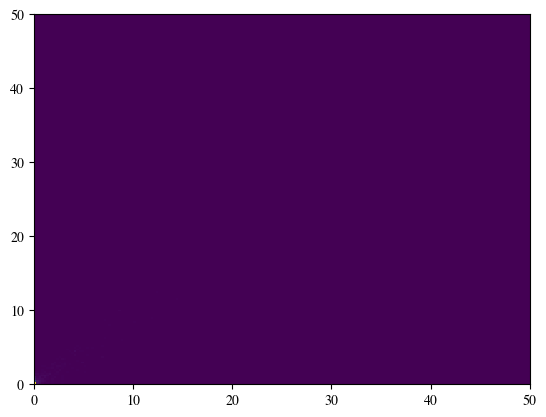

In [9]:
# Compute the correlations and add area for the central gene to the table
results_path = Path("../runs/test_runs/gene_expression_only_chrom_pure_conv/") #Path("../runs/test_runs/gene_expression_only_chrom_pure_conv/") #chrom_and_microc_with_attention") #Path("/Users/wjq311/Desktop/PhD/Enhancer_logic_project/Data/results_all/results_no_H3K27ac_uncoupled/expression_output")
gene_pos_path: Path = Path("../annotations/gene_enhancer_relationships_corrected.tsv")
input_table_path: Path = Path("../annotations/gene_enhancer_relationships_perturbed.csv")

figure_path = Path("../figures/Figure_1/")
figure_path.mkdir(parents=True, exist_ok=True)

condition_list = ["_ctrl"] #[""]
cmap = "binary"

pred_list_A_per_bin_dict, actual_list_A_per_bin_dict, pred_list_values_dict, actual_list_values_dict = calculate_correlations(results_path, gene_pos_path,figure_path, input_table_path)

for condition in condition_list:
    # Prediction of all bins (1kbp resolution)
    pred_list_values = np.log2(np.array(pred_list_values_dict[condition])+1) # Multiplying by 10 to convert from reads to decareads
    actual_list_values = np.log2(np.array(actual_list_values_dict[condition])+1)
    #pointwise = plot_correlations(figure_path, pred_list_values, actual_list_values, condition + "_binpred_noH3K27ac", cmap=cmap, binlims=(-10,100))
    pointwise = plot_correlations(figure_path, pred_list_values, actual_list_values, condition + "_pointwise_prediction", cmap=cmap, binlims=(0,10))

    # Central gene area (divided by gene length, equiv. to averaged EU-seq signal for the target gene)
    pred_list_values = np.array(pred_list_A_per_bin_dict[condition]) 
    actual_list_values = np.array(actual_list_A_per_bin_dict[condition])
    area = plot_correlations(figure_path, pred_list_values, actual_list_values, condition + "_gene_area_lengthnorm_prediction", cmap=cmap, density=False)


pointwise_avg = plot_correlations(figure_path, np.concatenate([pred_list_values_dict[condition] for condition in condition_list]), np.concatenate([actual_list_values_dict[condition] for condition in condition_list]), "_binpred_noH3K27ac_both_conditions", cmap="afmhot", binlims=(-10,100))
area = plot_correlations(figure_path, np.concatenate([pred_list_A_per_bin_dict[condition] for condition in condition_list]), np.concatenate([actual_list_A_per_bin_dict[condition] for condition in condition_list]), condition + "_gene_area_norm_noH3K27ac_both_conditions", cmap="afmhot", density=False)


**Benchmark models predictions: Enformer and Hyenadna**

> Note: Create a folder ../benchmarks/Hyena/ and move the predictions (which were by default saved in the scripts directory).


Index(['ENSMUSG00000028635.7_forward', 'ENSMUSG00000028989.3_forward',
       'ENSMUSG00000034785.14_forward', 'ENSMUSG00000028496.17_forward',
       'ENSMUSG00000039298.16_forward', 'ENSMUSG00000094066.1_forward',
       'ENSMUSG00000028820.13_forward', 'ENSMUSG00000040728.15_forward',
       'ENSMUSG00000028619.15_forward', 'ENSMUSG00000029047.13_forward',
       'ENSMUSG00000028648.13_forward', 'ENSMUSG00000029005.4_forward',
       'ENSMUSG00000078716.10_forward', 'ENSMUSG00000043085.14_forward',
       'ENSMUSG00000050395.9_forward', 'ENSMUSG00000094293.1_forward',
       'ENSMUSG00000028417.3_forward', 'ENSMUSG00000006215.12_forward',
       'ENSMUSG00000025413.13_forward', 'ENSMUSG00000073988.13_forward',
       'ENSMUSG00000029076.14_forward', 'ENSMUSG00000039410.16_forward',
       'ENSMUSG00000060268.12_forward', 'ENSMUSG00000002384.2_forward',
       'ENSMUSG00000078772.2_forward', 'ENSMUSG00000028560.11_forward',
       'ENSMUSG00000029029.14_forward', 'ENSMUSG00000028403.

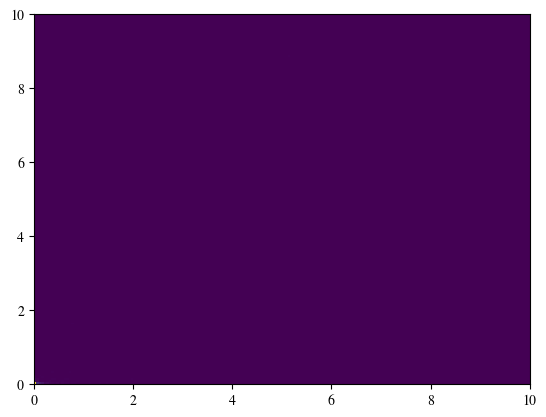

In [17]:
#####
# Paths:    
data_and_path_dict = {"hyenadna":{"predictions":np.load(Path("../benchmarks/Hyena/Hyena_finetunned_predictions.npy")).flatten(),
                                  "actual": np.load(Path("../benchmarks/Hyena/Hyena_finetunned_targets.npy")).flatten(),
                                  "figure_path":Path("../figures/supplementary_figures/Hyena_benchmarks/")},
                      "Enformer":{"predictions":np.load(Path("../benchmarks/Enformer/enformer_test_predictions.npy")).flatten(),
                                  "actual":np.load(Path("../benchmarks/Enformer/enformer_test_targets.npy")).flatten(),
                                  "figure_path":Path("../figures/supplementary_figures/Enformer_benchmarks/")}}

gene_pos_path: Path = Path("../annotations/gene_enhancer_relationships_corrected.tsv")
resolution = 1000
results_path = Path("../runs/test_runs/gene_expression_only_chrom_pure_conv/") #Path("/Users/wjq311/Desktop/PhD/Enhancer_logic_project/Data/results_all/results_no_H3K27ac_uncoupled/expression_output")
target_samples = pd.read_csv(Path("../targets/test_targets.csv"), sep=",").set_index("ID")
target_samples = target_samples[~target_samples.index.str.contains('_rev')]

print(target_samples.index[::-23])
condition_list = ["_ctrl"] #[""]

READ_SCALING_FACTOR = 1
PLOT_LIST =  ['ENSMUSG00000078673.10_forward', 'ENSMUSG00000054885.11_forward',
       'ENSMUSG00000089773.7_forward', 'ENSMUSG00000046133.3_forward',
       'ENSMUSG00000040372.2_forward', 'ENSMUSG00000028784.14_forward',
       'ENSMUSG00000050234.7_forward', 'ENSMUSG00000057375.13_forward',
       'ENSMUSG00000111410.1_forward', 'ENSMUSG00000006442.10_forward',
       'ENSMUSG00000078672.2_forward', 'ENSMUSG00000028602.12_forward',
       'ENSMUSG00000024793.14_forward', 'ENSMUSG00000078626.2_forward',       
       'ENSMUSG00000078490.10_forward', 'ENSMUSG00000028902.4_forward',
       'ENSMUSG00000042380.8_forward', 'ENSMUSG00000115115.1_forward',
       'ENSMUSG00000033253.18_forward', 'ENSMUSG00000028788.14_forward',
       'ENSMUSG00000036896.5_forward', 'ENSMUSG00000017264.16_forward',
       'ENSMUSG00000028743.7_forward', 'ENSMUSG00000028699.9_forward',
       'ENSMUSG00000063172.13_forward', 'ENSMUSG00000111611.1_forward',
       'ENSMUSG00000033326.15_forward', 'ENSMUSG00000057722.17_forward',
       'ENSMUSG00000023153.9_forward', 'ENSMUSG00000028635.7_forward',
       'ENSMUSG00000036896.5_forward',
       'ENSMUSG00000115115.1_forward', 'ENSMUSG00000078490.10_forward',
       'ENSMUSG00000028476.13_forward', 'ENSMUSG00000037692.14_forward',
       'ENSMUSG00000028950.3_forward', 'ENSMUSG00000045589.7_forward',
       'ENSMUSG00000078674.2_forward', 'ENSMUSG00000028634.17_forward',
       'ENSMUSG00000036887.5_forward', 'ENSMUSG00000028948.16_forward',
       'ENSMUSG00000028214.13_forward', 'ENSMUSG00000028410.13_forward',
       'ENSMUSG00000061455.13_forward', 'ENSMUSG00000028576.12_forward',
       'ENSMUSG00000020220.16_forward', 'ENSMUSG00000057375.13_forward',
       'ENSMUSG00000028339.17_forward', 'ENSMUSG00000039774.12_forward',
       'ENSMUSG00000066191.12_forward', 'ENSMUSG00000041120.6_forward',
       'ENSMUSG00000028917.14_forward', 'ENSMUSG00000010517.7_forward',
       'ENSMUSG00000061887.14_forward', 'ENSMUSG00000048626.5_forward',
       'ENSMUSG00000028549.17_forward', 'ENSMUSG00000009640.11_forward',
       'ENSMUSG00000078719.2_forward', 'ENSMUSG00000037443.13_forward',
       'ENSMUSG00000028467.15_forward', 'ENSMUSG00000028553.12_forward',
       'ENSMUSG00000028847.8_forward', 'ENSMUSG00000028976.10_forward',
       'ENSMUSG00000028245.15_forward', 'ENSMUSG00000028980.14_forward',
       'ENSMUSG00000039911.13_forward', 'ENSMUSG00000042608.15_forward',
       'ENSMUSG00000028312.19_forward', 'ENSMUSG00000041153.9_forward',
       'ENSMUSG00000054659.13_forward', 'ENSMUSG00000047613.10_forward',
       'ENSMUSG00000039546.9_forward', 'ENSMUSG00000039577.17_forward',
       'ENSMUSG00000028688.13_forward', 'ENSMUSG00000005045.16_forward',
       'ENSMUSG00000043383.5_forward', 'ENSMUSG00000063077.15_forward',
       'ENSMUSG00000070985.3_forward', 'ENSMUSG00000062545.4_forward',
       'ENSMUSG00000061894.15_forward', 'ENSMUSG00000028974.13_forward',
       'ENSMUSG00000028857.16_forward', 'ENSMUSG00000055900.14_forward',
       'ENSMUSG00000028779.16_forward', 'ENSMUSG00000003810.13_forward',
       'ENSMUSG00000028614.14_forward', 'ENSMUSG00000040372.2_forward',
       'ENSMUSG00000028648.13_forward', 'ENSMUSG00000029005.4_forward',
       'ENSMUSG00000078716.10_forward', 'ENSMUSG00000043085.14_forward',
       'ENSMUSG00000050395.9_forward', 'ENSMUSG00000094293.1_forward',
       'ENSMUSG00000028417.3_forward', 'ENSMUSG00000006215.12_forward',
       'ENSMUSG00000025413.13_forward', 'ENSMUSG00000073988.13_forward',
       'ENSMUSG00000029076.14_forward', 'ENSMUSG00000039410.16_forward',
       'ENSMUSG00000060268.12_forward', 'ENSMUSG00000002384.2_forward',
       'ENSMUSG00000078772.2_forward', 'ENSMUSG00000028560.11_forward',
       'ENSMUSG00000029029.14_forward', 'ENSMUSG00000028403.15_forward',
       'ENSMUSG00000028656.14_forward', 'ENSMUSG00000087166.9_forward',
       'ENSMUSG00000042608.15_forward', 'ENSMUSG00000048706.3_forward',
       'ENSMUSG00000037157.8_forward', 'ENSMUSG00000042616.8_forward',
       'ENSMUSG00000043257.15_forward', 'ENSMUSG00000028786.15_forward',
       'ENSMUSG00000078513.2_forward', 'ENSMUSG00000028393.10_forward',
       'ENSMUSG00000028277.13_forward', 'ENSMUSG00000040536.15_forward',
       'ENSMUSG00000045699.4_forward', 'ENSMUSG00000025328.9_forward',
       'ENSMUSG00000028851.6_forward', 'ENSMUSG00000028794.13_forward',
       'ENSMUSG00000028772.19_forward', 'ENSMUSG00000028763.18_forward',] 

plot_benchmark_models_predictions(data_and_path_dict, results_path,target_samples,condition_list, READ_SCALING_FACTOR,PLOT_LIST,  gene_pos_path, resolution)

 **Model performance comparison**

Comparison shown in Figure 3.
> *Note: Since we only want forward strand sequence predictions, we will remove the "_rev" samples from the enformer's test (both in target csv and input npy arrays)*

In [30]:
figure_path = Path("../figures/Figure_2/")
performance_dicts = [{"Enformer embeddings":{"Spearman":0.8067,"Pearson":0.8739},
                    "HyenaDNA-32k fine tuned":{"Spearman":0.7514,"Pearson":0.7403},
                    "Convolutions \non chomatin marks":{"Spearman":0.7814,"Pearson":0.8852},
                    "Convolutions and attention \non chromatin marks":{"Spearman":0.7815,"Pearson":0.8808},
                    "Convolutions \non chromatin marks and structure rotated":{"Spearman":0.7717,"Pearson":0.8690},
                    "Convolutions \non chromatin marks and structure original":{"Spearman":0.7066,"Pearson":0.8025}},
                    {"Enformer embeddings":{"Spearman":0.9093,"Pearson":0.7874}, #Areas from here
                    "HyenaDNA-32k fine tuned":{"Spearman":0.8053,"Pearson":0.5247},
                    "CLASTER":{"Spearman":0.9275,"Pearson":0.8859}}]
                    
color_list = ["orange","darkred","silver","black","royalblue","purple"]

cmap = plt.cm.inferno  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey

cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
norm = mpl.colors.Normalize(vmin=0, vmax=6)
color_list = [cmap(norm(i)) for i in range(6)]

model_comparison(figure_path, performance_dicts[0], color_list)

performance_dicts = [{"Enformer embeddings":{"Spearman":0.8067,"Pearson":0.8739},
                    "HyenaDNA-32k fine tuned":{"Spearman":0.7514,"Pearson":0.7403},
                    "CLASTER":{"Spearman":0.7717,"Pearson":0.8690}},
                    {"Enformer embeddings":{"Spearman":0.9093,"Pearson":0.7874}, #Areas from here
                    "HyenaDNA-32k fine tuned":{"Spearman":0.8053,"Pearson":0.5247},
                    "CLASTER":{"Spearman":0.9275,"Pearson":0.8859}}]


model_comparison_II(figure_path, performance_dicts, color_list[::2])

{'Enformer embeddings': {'Spearman': 0.8067, 'Pearson': 0.8739}, 'HyenaDNA-32k fine tuned': {'Spearman': 0.7514, 'Pearson': 0.7403}, 'CLASTER': {'Spearman': 0.7717, 'Pearson': 0.869}}
{'Enformer embeddings': {'Spearman': 0.9093, 'Pearson': 0.7874}, 'HyenaDNA-32k fine tuned': {'Spearman': 0.8053, 'Pearson': 0.5247}, 'CLASTER': {'Spearman': 0.9275, 'Pearson': 0.8859}}


## <center> _In silico_ perturbations <center>

**Figure 2 and related supplementary figures**



> ⏰ The following step takes a few minutes

We will first add the area under the reference gene when silencing a given enhancer.

In [5]:
results_path = Path("../runs/perturbation_runs/gene_expression_only_chrom_pure_conv/")
figure_path = Path("../figures/Figure_1/")
gene_pos_path: Path = Path("../annotations/gene_enhancer_relationships_corrected.tsv")
input_table_path: Path = Path("../annotations/gene_enhancer_relationships_perturbed.csv")

add_gene_area_after_enhancer_perturbation(results_path, gene_pos_path, figure_path, input_table_path,  N_BINS =  200, condition_list = ["_ctrl"], resolution = 1000)

/tmp/ipykernel_1912029/3114433919.py:251: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5751251853866663' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Ref_gene'] == gene) & (df['Entity_ID'] == enhancer),'Area'] = pred_area #Edit existing table


In [17]:
input_table_path: Path = Path("../annotations/gene_enhancer_relationships_perturbed.csv")
table = pd.read_csv(input_table_path)

table[table["Ref_gene"] == "ENSMUSG00000039693.11"]

,Ref_gene,Ref_gene_chromosome,Ref_gene_strand,Entity_ID,Entity_rel_Start,Entity_rel_End,EP_distance,Genes_in_between,Adjacent,Area
3341,ENSMUSG00000039693.11,chr4,+,ENSMUSG00000039693.11,0,21984,10992.0,0,1,9.970527
3342,ENSMUSG00000039693.11,chr4,+,EM10E0755362,-67572,-67288,67430.0,0,1,10.147307
3343,ENSMUSG00000039693.11,chr4,+,EM10E0755363,-67276,-67039,67157.5,0,1,10.256321
3344,ENSMUSG00000039693.11,chr4,+,EM10E0755376,847,1162,1004.5,0,1,8.202687
3345,ENSMUSG00000039693.11,chr4,+,EM10E0755407,44761,44952,44856.5,1,0,9.915334
3346,ENSMUSG00000039693.11,chr4,+,EM10E0755409,45533,45856,45694.5,1,0,9.558456
3347,ENSMUSG00000039693.11,chr4,+,EM10E0755410,45866,46172,46019.0,1,0,9.395018
3348,ENSMUSG00000039693.11,chr4,+,EM10E0755411,46222,46424,46323.0,1,0,9.555614
3349,ENSMUSG00000039693.11,chr4,+,EM10E0755412,46508,46849,46678.5,1,0,9.795846
3350,ENSMUSG00000039693.11,chr4,+,EM10E0755364,-66973,-66770,66871.5,0,1,10.172708


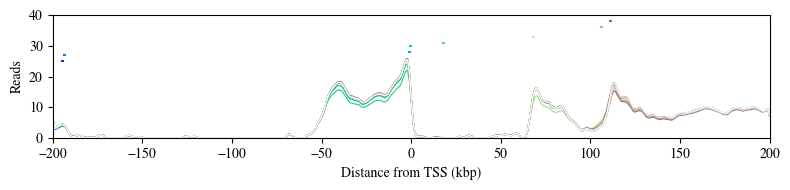

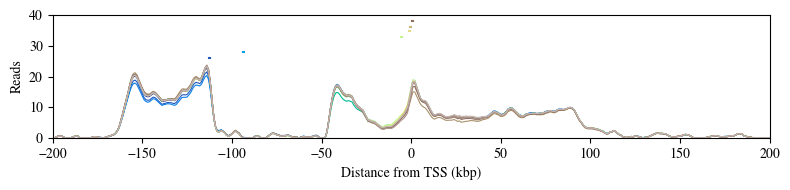

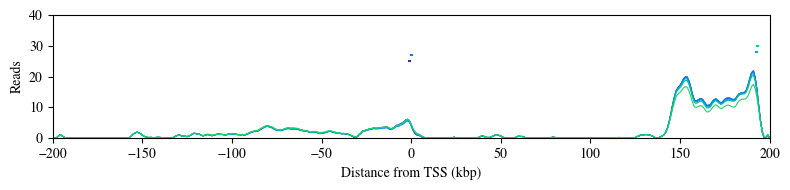

In [34]:
import matplotlib as mpl

# Plot perturbed profile predictions
results_path = Path("../runs/perturbation_runs/gene_expression_pure_conv_perturbed_only_H3K27ac") # Path("../runs/perturbation_runs/gene_expression_only_chrom_pure_conv/") # Change plot name to _original
N_BINS = 200
SCALE = 1000
PERT_TYPE = "only_H3K27ac"
figure_path = Path("../figures/Figure_2/")
sample_names = ["ENSMUSG00000028345.15", "ENSMUSG00000028347.14","ENSMUSG00000028344.12" ]#table['Ref_gene'].unique()[::10] #[ "ENSMUSG00000000409.14", "ENSMUSG00000000085.16", ]

for sample_name in sample_names:
    plot_perturbed_profiles(results_path, figure_path, N_BINS, SCALE, sample_name, PERT_TYPE)

We will now compute:
1) The distance dependence of the in-silico enhancer silencing impact.
2) Which genes are the most affected and what's their relative location to the affected gene.
- We will first compute all the E-P pairs that are available. 
- We will store separately, for each enhancer, the gene that was the most affected and its relative properties to the enhancer (distance, adjacency and number of genes in between E and P).
- We will histogram the properties of the most affected gene and normalize by the background frequencies: While most enhancers might have zero or 1 gene in between, it is rare that an enhancer will have 15 genes between it and another gene that appears in the same sample. Weapplied a reciprocal normalization, i.e. as if we had a dataset with the same number of cases for all categories, which allows us to compare the enrichment on certain categories relative to the "background".

⚠️ The different histograms follow parallel normalization schemes, yielding an apparent discrepancy between adjacent cases and "0 genes in between".

> ⚠️ IMPORTANT NOTE: Run first the cell where correlations are predicted for the model you used for the perturbed predictions. Otherwise the comparisons do not make sense!!!



/tmp/ipykernel_2263363/2841167992.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Absolute_Relative_Change'] = abs(
/tmp/ipykernel_2263363/2841167992.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enhancers_filtered['EP_distance_bin'] = pd.cut(enhancers_filtered['EP_distance'], bins=bins, include_lowest=True)
/maps/projects/rasmussen/data/enhancer_logic_project/claster_env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 25.4% of the points cannot be placed; you

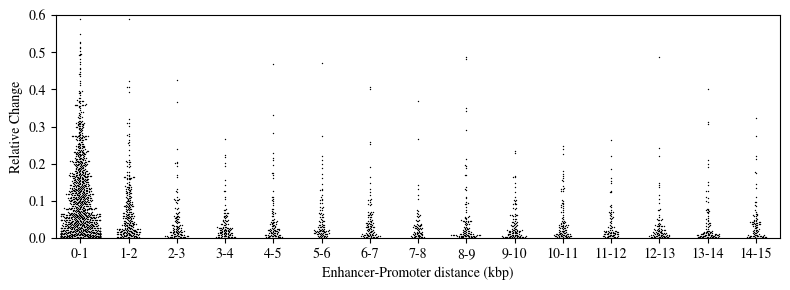

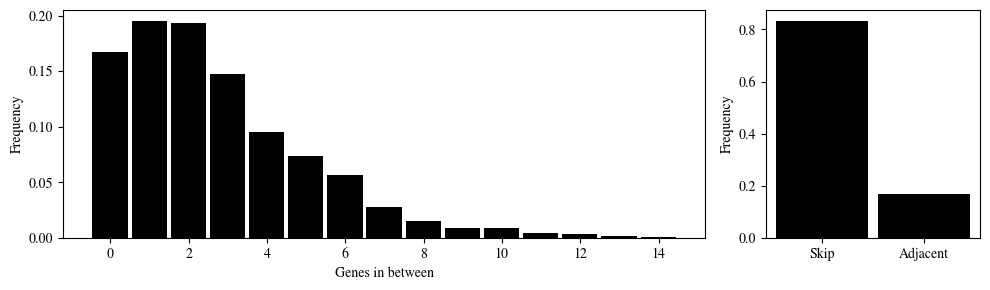

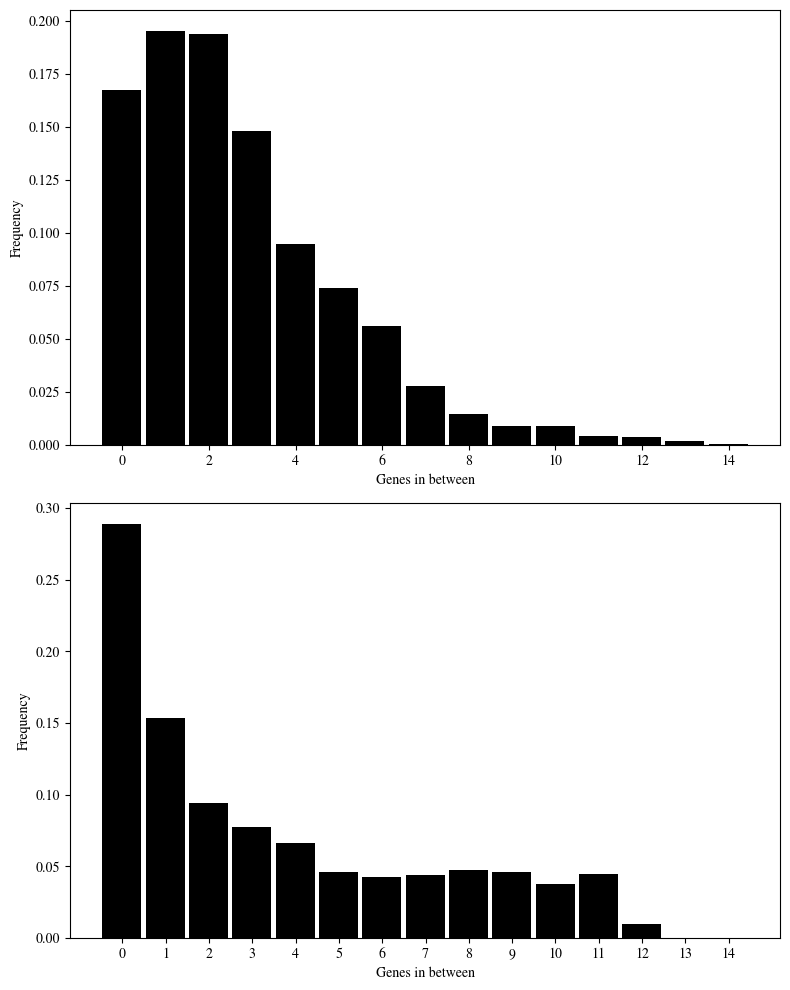

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

def calculate_histogram(data, bins):
    """
    Calculate the histogram of given data.
    
    Args:
        data (array-like): The data for which to calculate the histogram.
        bins (array-like): The bin edges.

    Returns:
        hist (np.ndarray): The counts of data in each bin.
        bins (np.ndarray): The edges of the bins.
    """
    hist, bins = np.histogram(data, bins=bins)
    return hist.astype(np.float32), bins

def plot_normalized_histogram(ax, data, reference_data=None, bins=np.arange(-0.5, 15.6, 1), eps=0.1, color='royalblue', xlabel='', ylabel='Frequency', xticks=None, xticklabels=None):
    """
    Plot a normalized histogram, optionally normalizing against a reference distribution, with explicit x-ticks.
    
    Args:
        ax (matplotlib.axes.Axes): The axes object to plot on.
        data (array-like): The data to plot.
        reference_data (array-like, optional): The reference data for normalization.
        bins (array-like): The bin edges.
        eps (float): Epsilon value for adjusting bar width.
        color (str): Color of the histogram bars.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label.
        xticks (list, optional): Positions of the x-ticks. If None, automatic x-ticks will be used.
        xticklabels (list of str, optional): Labels of the x-ticks. If None, labels are generated from xticks.
    """
    hist, bins = calculate_histogram(data, bins)
    frequency_vector = hist / hist.sum()  # Normalize to sum to 1
    
    if reference_data is not None:
        reference_hist, _ = calculate_histogram(reference_data, bins)
        reference_frequency = reference_hist / reference_hist.sum()
        frequency_vector = frequency_vector / reference_frequency
        frequency_vector /= frequency_vector.sum()  # Re-normalize to sum to 1
    
    ax.bar(bins[:-1], frequency_vector, width=(bins[1]-bins[0] - eps), color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Set x-ticks if specified
    if xticks is not None and xticklabels is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, rotation=0)  # Adjust rotation as needed for readability
    elif xticks is not None:
        ax.set_xticks(xticks)
        # Generate automatic xticklabels if only xticks are provided
        ax.set_xticklabels([f"{tick:.1f}" for tick in xticks], rotation=0)


def plot_perturbation_histograms(df, figure_path):
    # Filter out rows where Area is 0.0 for reference genes and their enhancers
    non_zero_ref_genes = df[df['Area'] > 0.0]['Ref_gene'].unique()
    df_filtered = df[df['Ref_gene'].isin(non_zero_ref_genes)]
    
    # Calculate Absolute Relative Change
    df_filtered['Absolute_Relative_Change'] = abs(
        (df_filtered['Area'] - df_filtered.groupby('Ref_gene')['Area'].transform('first')) /
        df_filtered.groupby('Ref_gene')['Area'].transform('first')
    )

    # Exclude rows where Ref_gene equals Entity_ID (gene rows) to focus on enhancers
    enhancers_filtered = df_filtered[df_filtered['Ref_gene'] != df_filtered['Entity_ID']]

    # Bin EP_distance into 1000 bp bins
    max_distance = 15000
    min_distance = 0
    scale = 1000
    bins = np.arange(min_distance - min_distance % scale, max_distance + scale, scale)  # Create bins edges
    enhancers_filtered['EP_distance_bin'] = pd.cut(enhancers_filtered['EP_distance'], bins=bins, include_lowest=True)

    # Plot Swarm Plots with Binned EP_distance
    fig = plt.figure(figsize=(8, 3))
    sns.swarmplot(x='EP_distance_bin', y='Absolute_Relative_Change', data=enhancers_filtered, color='k', size=1)
    plt.xlabel('Enhancer-Promoter distance (kbp)')
    plt.ylabel('Relative Change')
    plt.xticks(np.arange(15), [f"{a}-{a+1}" for a in range(15)])  # Improve label readability
    plt.ylim((0, .6))
    plt.tight_layout()
    fig.savefig(figure_path / "Distance_effect.png", dpi=200)

    # Filter DataFrame to keep only rows with the largest Absolute_Relative_Change for each enhancer
    enhancers_largest_change = enhancers_filtered.groupby('Entity_ID').apply(lambda x: x.nlargest(1, 'Absolute_Relative_Change')).reset_index(drop=True)

    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    fig = plt.figure(figsize=(10, 3))

    # Plot frequency histograms for all Enhancer-Promoter interactions
    ax1 = fig.add_subplot(gs[0, 0]) 
    ax2 = fig.add_subplot(gs[0, 1])

    plot_normalized_histogram(
        ax1,
        data=enhancers_filtered['Genes_in_between'],
        bins=np.arange(-0.01, 15.6, 1),
        xlabel='Genes in between',
        ylabel='Frequency',
        color='k'
    )
    plot_normalized_histogram(
        ax2,
        data=enhancers_filtered['Adjacent'],
        xlabel='',
        bins=[0,1,2],
        ylabel='Frequency',
        xticks = np.arange(2),
        xticklabels = ['Skip','Adjacent'],
        color='k'
    )
    plt.tight_layout()
    fig.savefig(figure_path / "Background_frequencies.png", dpi=200)

    # Plot histograms for most relevant EP interactions with normalization against the background distribution

    gs = gridspec.GridSpec(2, 1)
    fig = plt.figure(figsize=(8, 10))

    # Plot frequency histograms for all Enhancer-Promoter interactions
    ax1 = fig.add_subplot(gs[0, 0]) 
    ax2 = fig.add_subplot(gs[1, 0])

    plot_normalized_histogram(
    ax1,
    data=enhancers_filtered['Genes_in_between'],
    bins=np.arange(-0.01, 15.6, 1),
    xlabel='Genes in between',
    ylabel='Frequency',
    color='k'
    )

    plot_normalized_histogram(
        ax2,
        data=enhancers_largest_change['Genes_in_between'],
        reference_data=enhancers_filtered['Genes_in_between'],
        bins=np.arange(-0.01, 15.6, 1),
        xlabel='Genes in between',
        ylabel='Frequency',
        xticks = np.arange(15),
        xticklabels = np.arange(15),
        color='k'

    )
    # plot_normalized_histogram(
    #     ax2,
    #     data=enhancers_largest_change['Adjacent'],
    #     #reference_data=enhancers_filtered['Adjacent'],
    #     bins=[0,1,2],
    #     xlabel='',
    #     ylabel='Frequency',
    #     xticks = np.arange(2),
    #     xticklabels = ['Skip','Adjacent'],
    #     color='k'
    # )
    plt.tight_layout()
    fig.savefig(figure_path / "Normalized_frequency_hist.png", dpi=200)


plot_perturbation_histograms(table, Path("../figures/Figure_2/"))


**Figure 2b: Chromatin mark correlations**

Visualize possible chromatin states found in the data.

In [55]:
array_path = Path("../inputs/landscape_arrays/test/")
figure_path = Path("../figures/Figure_2/")
figure_path.mkdir(parents=True, exist_ok=True)
skip_n_bins = 20 #20

plot_chromatin_state_combinations(array_path, figure_path, skip_n_bins)

# <center> Attributions <center>

Now we will compute the attribution scores for every input position (4,10.001) towards every output (401). This mechanism tells how important is every input position (i.e. a given bin in each input track in the landscape or a given bin in a Micro-C matrix) for the prediction of the EU-seq levels at the position described by a given target node (401 targets). It also tells us the direction of the association.
The original paper can be found at:

https://arxiv.org/abs/1703.01365

EIR uses the integrated gradients method as it is implemented in the captum library:

https://captum.ai/docs/extension/integrated_gradients


**Figure 3 and related supplementary figures**

/tmp/ipykernel_122633/2179293752.py:449: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centered_attr = np.roll(attributions, -10*i+int(eps),axis=1)


KeyboardInterrupt: 

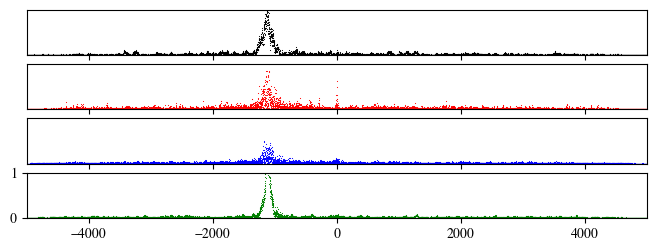

In [61]:
results_path = Path("../runs/test_runs/gene_expression_microc_rotated_pure_conv/expression_output/") #Path("../runs/gene_expression_only_chrom_pure_conv/results/expression_output/") #Path("../runs/training_runs/gene_expression_exformer_unlimited_all_rotated/results/expression_output/")
figure_path = Path("../figures/Figure_3/")
figure_path.mkdir(parents=True, exist_ok=True)
n_central_bins = 401
l_in:int = 10001
n_out:int=401
n_in: int=4

track_dict: dict = {0:{"name":"ATAC-seq","function":"Chromatin accessibility","color":"k"},
        1:{"name":"H3K4me3","function":"Promoter","color":"r"},
        2:{"name":"H3K27ac","function":"Enhancer","color":"blue"},
        3:{"name":"H3K27me3","function":"Chromatin silencing","color":"g"}}
TRAIN_ATTR: bool = False
SPLIT = 60600 #17880
read_target_attributions(results_path, figure_path, n_central_bins, track_dict,l_in,n_out,n_in, TRAIN_ATTR,SPLIT)


results_path = Path("../runs/gene_expression_only_chrom_pure_conv/results/expression_output/")
figure_path = Path("../figures/Figure_3_only_chrom/")
figure_path.mkdir(parents=True, exist_ok=True)
TRAIN_ATTR: bool = True
SPLIT = 60600 #17880
read_target_attributions(results_path, figure_path, n_central_bins, track_dict,l_in,n_out,n_in, TRAIN_ATTR,SPLIT)



**Micro-C Matrices: Original and rotated**

In [17]:
name = "ENSMUSG00000059552.13_forward.npy" #"ENSMUSG00000024406.16_forward.npy" # ENSMUSG00000028948.16_forward ENSMUSG00000078626.2_forward ENSMUSG00000046667.14_rev # Original paper example "ENSMUST00000105369.7.npy" #"ENSMUST00000002350.10_flipped"
pathlist = [Path('../inputs/microC/training/'), Path('../inputs/microC_rotated/training/')]
figure_path = Path("../figures/supplementary_figures/")
figure_path.mkdir(exist_ok=True, parents=True)
num_bins = 626
window_of_observation = 707.10678118  # kbp (diagonal is not observing the same length in the genome.)

plot_microc_original_and_rotated(pathlist, figure_path, num_bins, window_of_observation, name)

**Micro-C attributions**

In [67]:
figure_path = Path("../figures/Figure_3/")

sample_ids = range(-200,201)
num_bins = 626
window_of_observation = 707.10678118  # kbp (diagonal is not observing the same length in the genome.)
#bins_per_kbp = 0.885297690046
ATTR_type_list = ["abs","signed"]
conditions = ["_ctrl"]
sigma = 3

plot_microc_attributions(figure_path, sample_ids, num_bins, window_of_observation, ATTR_type_list, conditions, sigma)

0.885297690053755


/tmp/ipykernel_122633/2171253213.py:587: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_122633/2171253213.py:663: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


**Filter visualization**

We can visualize the activations of a set of predefined filters, in this case for the structural branch handling Micro-C matrices. We can see what is the network propagating forward or what features are extracted.

-2.021034002304077 1.9138600826263428
-2.020750045776367 1.8846609592437744
-1.9546396732330322 1.9160393476486206
-1.8921006917953491 1.9064550399780273
-2.0078046321868896 1.928229570388794
-1.9475384950637817 1.9080767631530762
-7.166399002075195 2.429628372192383
-7.975045680999756 2.919764757156372
-7.415754318237305 2.5516605377197266
-7.684394359588623 2.1006875038146973
-7.582004547119141 2.4546499252319336
-7.244106769561768 3.086484909057617
-3.6593098640441895 1.1407158374786377
-3.393815517425537 1.2011475563049316
-3.6953325271606445 0.9598491787910461
-3.430828332901001 1.0976873636245728
-3.5928092002868652 1.1078323125839233
-3.9535763263702393 1.1592458486557007
-5.639556884765625 1.5351132154464722
-5.4008917808532715 1.2717441320419312
-5.332563877105713 1.413964033126831
-4.86221170425415 1.3372340202331543
-4.822977066040039 1.4820897579193115
-5.077983379364014 1.2805430889129639


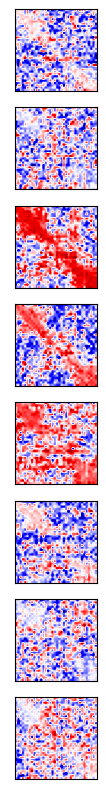

In [4]:
# Conv 0: first set of filters
root_path = Path("../runs/gene_expression_microc_pure_conv_latents/latents/latent_outputs/3600/")
path = root_path / "input_modules.contact_maps.feature_extractor.conv.0.conv_1" 
savepath = Path("../figures/supplementary_figures/filters/")
#path = Path("/Users/wjq311/Desktop/eir/runs/gene_expression_exformer_unlimited_all/latents/latent_outputs/29800/input_modules.contact_maps.feature_extractor.conv.0.conv_1/") 
visualize_filters(path,savepath, first_validation_sample_index = 1, last_validation_sample_index = 100, step= 1, layer_name= "layer_0.1") 

# # Conv 1: deeper set of filters
path = root_path / "input_modules.contact_maps.feature_extractor.conv.1.conv_1"
visualize_filters(path,savepath, first_validation_sample_index = 1, last_validation_sample_index = 100, step= 1, layer_name= "layer_1.1") 

# # Conv 2: deeper set of filters
path = root_path / "input_modules.contact_maps.feature_extractor.conv.2.conv_1" 
visualize_filters(path, savepath, first_validation_sample_index = 1, last_validation_sample_index = 100, step= 1, layer_name= "layer_2.1") 

# # Conv 3: deeper set of filters
path = root_path / "input_modules.contact_maps.feature_extractor.conv.3.conv_1" 
visualize_filters(path, savepath, first_validation_sample_index = 1, last_validation_sample_index = 100, step= 1, layer_name= "layer_3.1") 

**Smoothing and downresolving output profiles**
The main signal in the target EU-seq profiles oscillates at a hbp-kbp scale. Keeping bp resolution would:
- create a high number of outputs, complicating the computations of attributions for every input output pair.
- Constrain us to reduce the output window per sample. We could not be able to assess the effects of the perturbations on as many genes.
- It is not clear that the information to predict those wiggles in the signal is encoded in the inputs (core chrom. landscape marks).

Supplementary figure showing the downresolution of the targets



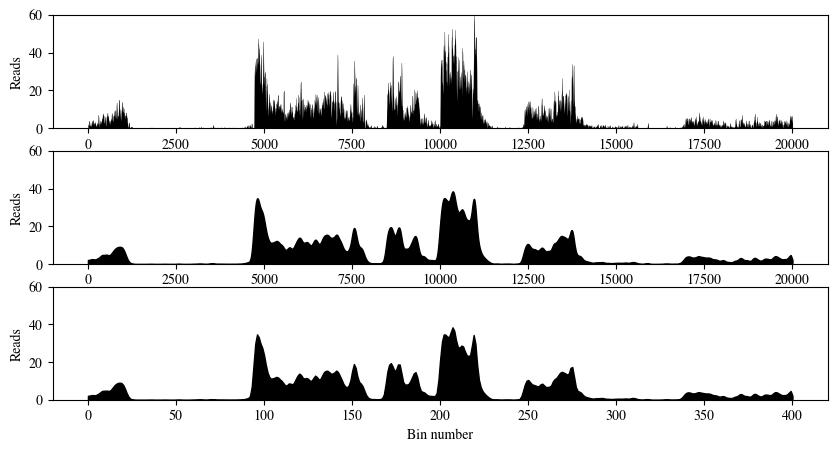

In [33]:
from typing import Optional
from scipy.ndimage import gaussian_filter1d
import pyBigWig

def smoothed_profiles(data_path: Path,
                      savepath: Path,
                      output_shift: int,
                      n_output_bins:int,
                      TSS: int,
                      chrom: str,
                      sigma:int,
                      binsize: int):
    """
    Targets are centered at the TSS, and obtained at a 20 bp resolution, smoothed and downsized to 1kbp resolution.
    """
    bw = pyBigWig.open(str(data_path), "r")
    stats = bw.stats(chrom,TSS-output_shift,TSS+output_shift,type="mean",nBins=n_output_bins)
    bw.close()
    stats = np.array([float(value) if value is not None else 0. for value in stats])
    stats = np.clip(np.array(stats),0,None)
    
    original_array = stats.copy()
    stats = gaussian_filter1d(stats, sigma=sigma)
    target_cond = np.zeros_like(stats)

    # Averaging over a number of bins
    for j in range(binsize):
        target_cond += 1 / binsize * np.roll(stats, -j)

    averaged_array = target_cond.copy()

    final_array = target_cond[::binsize]

    fig, axs = plt.subplots(3, figsize=(10,5))

    for i in range(len(axs)):
        axs[i].set_ylim((0,60))
        axs[i].set_ylabel("Reads")
    axs[-1].set_xlabel("Bin number")
    axs[0].fill_between(np.arange(len(original_array)), original_array, color='k', lw=.1)
    axs[1].fill_between(np.arange(len(averaged_array)), averaged_array, color='k')
    axs[2].fill_between(np.arange(len(final_array)), final_array, color='k')
    fig.savefig(savepath / "Smoothed_targets.png", dpi=200)

data_path = Path("../GEO_files/EU_Seq_Ctrl.bw")
savepath = Path("../figures/supplementary_figures/")
output_shift = 200010 # Output in 20 bp resolution (to be smoothed and downsampled)
n_output_bins = 20001
chrom = 'chr4'
TSS = 152039321
sigma = 50
binsize = 50

smoothed_profiles(data_path,
                  savepath, 
                  output_shift,
                  n_output_bins,
                  TSS,
                  chrom,
                  sigma,
                  binsize)


**Hyena and Enformer Embeddings**

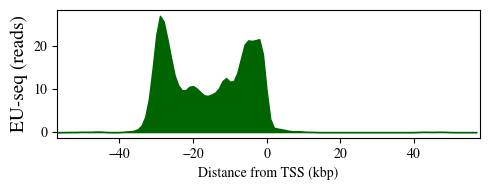

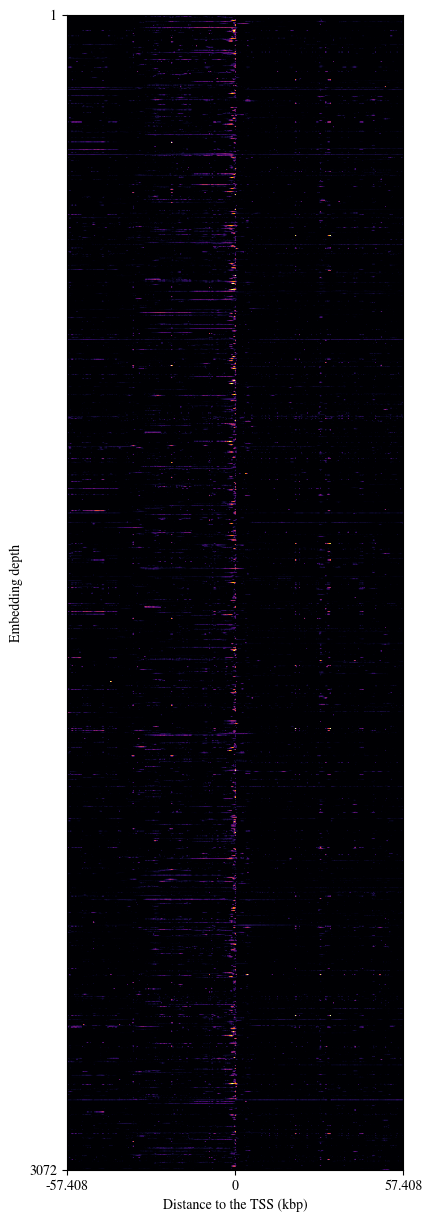

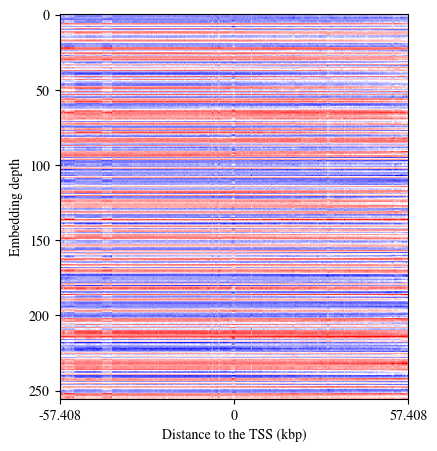

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path 
N_BINS = 57
SHIFT = 200

path = Path("../inputs/DNA_sequences")
sample_id = "ENSMUSG00000066324.2_forward.npy" #"ENSMUSG00000003282.9_forward.npy" 
a = np.load(path / "test_embeddings_Enformer" / sample_id )
b = pd.read_csv("../targets/test_targets.csv").set_index('ID')
d = np.load(path / "test_embeddings_Hyena-DNA" / sample_id)

savepath = Path("../figures/supplementary_figures/")

fig, axs = plt.subplots(1, figsize=(5,2))
axs.fill_between(np.arange(-N_BINS,N_BINS+1),b.loc[sample_id[:-4]][SHIFT-N_BINS:SHIFT+N_BINS+1], lw=1, color='darkgreen', label = "Control EU-seq target")
#axs.fill_between(np.arange(len(b.loc[sample_id[:-4]])//2),b.loc[sample_id[:-4]][len(b.loc[sample_id[:-4]])//2:], lw=1, color='goldenrod', alpha=.5, label="Treated")
axs.set_ylabel("EU-seq (reads)", rotation = 90, fontsize=14)
axs.set_xlim((-N_BINS,N_BINS+1))
#axs.set_yticks([0,6],[0,6])
#axs.set_ylim((0,6.5))
axs.set_xlabel("Distance from TSS (kbp)")
fig.tight_layout()
fig.savefig(savepath / f"Profile.png", dpi=200)


fig, axs = plt.subplots(1, figsize=(6,15))
plt.imshow(a[0].T, cmap='inferno', vmin = 0, vmax=2)
axs.set_xlabel("Distance to the TSS (kbp)", fontsize=10)
axs.set_xticks([0,448.5,896],[-57.408,0,57.408])
axs.set_yticks([0,3071],[1,3072])
axs.set_ylabel("Embedding depth")
plt.xlim((0,896))
fig.savefig(savepath / "Enformer_embedding.png", dpi = 200)


central_bins = 896
bp_per_bin = 128
central_width = central_bins*bp_per_bin
crop_distance = (160002-central_width)//2

fig3, axs = plt.subplots(1, figsize=(4.5,5))
data = d[0].T[:,crop_distance:-crop_distance:1]
axs.imshow(data, aspect='auto', cmap="seismic", vmin = -4, vmax = 4)
axs.set_xticks([0,data.shape[1]//2,data.shape[1]],[-57.408,0,57.408])
axs.set_xlabel("Distance to the TSS (kbp)", fontsize=10)
axs.set_ylabel("Embedding depth")
fig3.savefig(savepath / "Hyena_embeddings.png", dpi=200)

**Benchmark model loss evolution:**

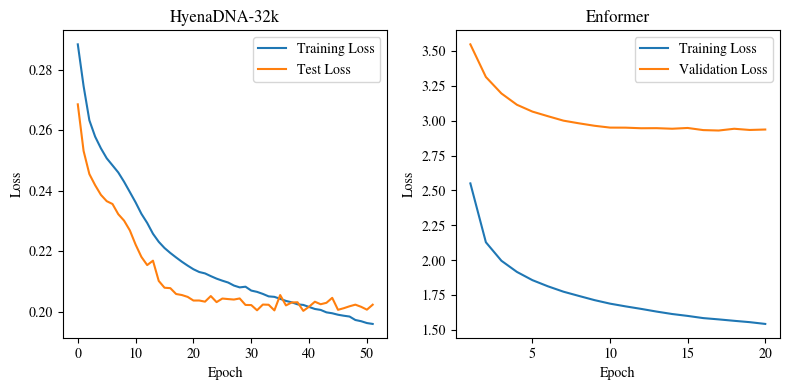

In [36]:
import re
import matplotlib.pyplot as plt

def plot_losses(hyena_log_file, enformer_log_file, savepath):
    # Function to read log file and extract losses
    def extract_losses(log_file, train_pattern, test_pattern=None):
        with open(log_file, 'r') as file:
            log_data = file.read()
        
        train_losses = []
        val_losses = []
        epochs = []

        train_matches = re.findall(train_pattern, log_data)
        if test_pattern:
            test_matches = re.findall(test_pattern, log_data)
        else:
            test_matches = []

        for match in train_matches:
            epochs.append(int(match[0]))
            train_losses.append(float(match[1]))
            if len(match) > 2:
                val_losses.append(float(match[2]))

        if test_pattern:
            for match in test_matches:
                val_losses.append(float(match))

        return epochs, train_losses, val_losses

    # Extract HyenaDNA-32k data
    hyena_train_pattern = r"Train Epoch: (\d+)\s+Average Loss: ([\d.]+)"
    hyena_test_pattern = r"Test set: Average loss: ([\d.]+)"
    hyena_epochs, hyena_train_losses, hyena_test_losses = extract_losses(hyena_log_file, hyena_train_pattern, hyena_test_pattern)

    # Extract Enformer data
    enformer_pattern = r"Epoch \[(\d+)/\d+\], Training Loss: ([\d.]+), Training R\^2: [\d.]+, Validation Loss: ([\d.]+), Validation R\^2: [\d.]+"
    enformer_epochs, enformer_train_losses, enformer_val_losses = extract_losses(enformer_log_file, enformer_pattern)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # HyenaDNA-32k plot
    axes[0].plot(hyena_epochs, hyena_train_losses, label='Training Loss', marker='')
    axes[0].plot(hyena_epochs, hyena_test_losses, label='Test Loss', marker='')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('HyenaDNA-32k')
    axes[0].legend()

    # Enformer plot
    axes[1].plot(enformer_epochs, enformer_train_losses, label='Training Loss', marker='')
    axes[1].plot(enformer_epochs, enformer_val_losses, label='Validation Loss', marker='')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Enformer')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(savepath, dpi=200)

# File paths
hyena_log_file = '../checkpoints/hyenadna_32k.log'
enformer_log_file = '../benchmarks/Enformer/training.log'
savepath = '../figures/supplementary_figures/Train_test_loss_curves_benchmark.png'

# Plot the losses
plot_losses(hyena_log_file, enformer_log_file, savepath)
